<a href="https://colab.research.google.com/github/evril7490/test/blob/master/Classification_EDA_ModelValuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV,ParameterGrid
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve,confusion_matrix
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import log_loss
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
font_size = 15
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

In [3]:
#### Explore Continuous variable

In [4]:
def explor_categorical_plots(train_df,
                             feat_cols,
                             target_col,
                             target_col_mapname=['Retained', 'Churned'],
                             colors = ['#00A5E0', '#DD403A'],
                             ):
  colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', 
                '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
  for feat_col in feat_cols:    
    fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))
    sns.countplot(x=target_col, data=train_df, palette=colors_cat,ax=ax0)
    ax0.set_ylabel('Count')
    sns.countplot(x=feat_col,
                  hue=target_col,
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    if target_col_mapname:
      ax1.legend(labels=target_col_mapname)
    sns.barplot(x=feat_col,
                y=target_col,
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    plt.tight_layout();

In [5]:
# general hist plot
def plot_continuous_for_classification(data,
                    feat_col,
                    target_col,
                    target_col_mapname=['Retained', 'Churned'],
                    colors = ['#00A5E0', '#DD403A'],
                    ):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = data.copy()
    df_retained = df_func[df_func[target_col]==0]
    df_churned  = df_func[df_func[target_col]==1]
    df_func[target_col] = df_func[target_col].astype('category')
    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})
    for df, color, label in zip([df_retained, df_churned], colors, target_col_mapname):
        sns.histplot(data=df,
                     x=feat_col,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
        ax1.legend()

    sns.boxplot(x=feat_col, y=target_col, data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    if target_col_mapname:
      ax2.set_yticklabels(target_col_mapname)
    plt.tight_layout();

def explor_continuous_plots(train_df,
                            feat_cols,
                            target_col,
                            target_col_mapname=['Retained', 'Churned'],
                            plot_cols=2,
                          ):
  #### continous variable histogram plot
  rows = (len(feat_cols)+plot_cols-1)//plot_cols
  fig, ax = plt.subplots(rows, plot_cols, figsize=(6*plot_cols, 5*rows))
  for index, column in enumerate(feat_cols):
    plt.subplot(rows, plot_cols, index + 1)
    train_df[column].hist(bins=20,
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);
    plt.title(column)
  plt.show()
  for col in feat_cols:
    plot_continuous_for_classification(train_df,col,target_col=target_col,target_col_mapname=target_col_mapname)
  #### correlation heatmap plot
  fig, ax = plt.subplots(figsize=(12, 12))
  corr = train_df[feat_cols].corr()
  np.fill_diagonal(corr.values, np.nan)
  sns.heatmap(corr,
            #annot=True,
            #annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

  ax.tick_params(axis='x', rotation=45)
  ax.tick_params(axis='y', rotation=360);

In [6]:
### Fill Na for categorical columns and continuous columns
def fill_na(df,category_cols=[], cont_cols=[],
            fill_category_value='unknown',
            fill_na_dict=None):
  X = df.copy()
  if not fill_na_dict:# we have not provided the fill_missing_dict
    fill_na_dict = {'category':{}}
    for col in category_cols:
      fill_na_dict['category'][col] = fill_category_value

    fill_na_dict['continous'] = {}
    for col in cont_cols:
      fill_na_dict['continous'][col] = X[col].mean()

  for cate_col,fill_value in fill_na_dict['category'].items():
    X[cate_col].fillna(fill_value,inplace=True)

  for col,col_mean in fill_na_dict['continous'].items():
    X[col].fillna(col_mean,inplace=True)

  return X,fill_na_dict


def target_encoder(df,feat_cols,target_col,post_fix='_TE',target_encode_dict=None):
  df = df.copy()
  if not target_encode_dict:
    target_encode_dict = {}
    for col in feat_cols:
      target_encode_dict[col] = dict(df.groupby(col)[target_col].mean())
  for col in feat_cols:
    df[f'{col}{post_fix}'] = df[col].map(target_encode_dict[col])
  
  return df,target_encode_dict

def one_hot_encoder(df,feat_cols,enc_dict=None):
  enc_df = []
  # if enc_dict is not provided, will run the feats and create the encode dict
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = OneHotEncoder(handle_unknown='ignore')
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = enc
  
  for feat_col in feat_cols:
    if feat_col in enc_dict:
      enc = enc_dict[feat_col]
      enc_df.append( pd.DataFrame(enc.transform(df[[feat_col]]).toarray(),columns= [ f'{feat_col}_{k}' for k in enc.categories_[0] ],index=df.index ) )
    else:
      print(f'Missing {feat_col} in the encoder dict')
  enc_df = pd.concat(enc_df,axis=1)
  for col in enc_df:
    if col in df:
      print(f'Will overwrite {col} since it already exist in df')
      df = df.drop(columns=[col])
  df = pd.concat([ df,enc_df], axis=1)
  return df,enc_dict

def label_encoder(df,feat_cols,enc_dict=None,postfix='_LE'):
  if not enc_dict:
    enc_dict = {}
    for feat_col in feat_cols:
      enc = LabelEncoder()
      enc.fit(df[[feat_col]])
      enc_dict[feat_col] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

  for feat_col in feat_cols:
    if feat_col in enc_dict:
      df[f'{feat_col}{postfix}'] = df[feat_col].map(enc_dict[feat_col])
    else:
      print(f'Missing {feat_col} in the encoder dict')
  return df,enc_dict


def preprocess_test(test_df,preprocess_dict):
  df = test_df.copy()
  if 'fill_na_dict' in preprocess_dict:
    for var_type, fill_na_value_dict in preprocess_dict['fill_na_dict'].items():
      for col,fill_na_value in fill_na_value_dict.items():
        print(f'fillna for {var_type} {col}')
        df[col].fillna(fill_na_value,inplace=True)
  if 'target_encode_dict' in preprocess_dict:
    for col,enc_dict in preprocess_dict['target_encode_dict'].items():
      print(f'target encode for {col}')
      df[col+'_TE'] = df[col].map(enc_dict)
  if 'one_hot_enc_dict' in preprocess_dict:
    enc_df = []
    for col,enc in preprocess_dict['one_hot_enc_dict'].items():
      print(f'one hot encode for {col}')
      enc_df.append( pd.DataFrame(enc.transform(df[[col]]).toarray(),columns= [ f'{col}_{k}' for k in enc.categories_[0] ],index=df.index ) )
    enc_df = pd.concat(enc_df,axis=1)
    for col in enc_df:
      if col in df:
        print(f'Will overwrite {col} since it already exist in df')
        df = df.drop(columns=[col])
    df = pd.concat([ df,enc_df], axis=1)
  
  if 'label_enc_dict' in preprocess_dict:
    for feat_col,enc_dict in preprocess_dict['label_enc_dict'].items():
      print(f'label encode for {feat_col}')
      df[f'{feat_col}_LE'] = df[feat_col].map(enc_dict)
  return df

In [7]:
def plot_feature_imp(classifier, feat_cols):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': feat_cols,
                                'Importance': np.round(classifier.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')
    importances.plot.barh(color='cadetblue',
                          edgecolor='firebrick',
                          legend=False,
                          figsize=(16,max(4,len(feat_cols)//2))
                          )
    plt.xlabel('Importance');
    return importances

def plot_conf_mx(cm, ax,target_col_mapname=['Retained', 'Churned']):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)
    ax.set_xlabel('Predicted Label'); 
    ax.set_xticks([0.5, 1.5]);
    ax.set_xticklabels(target_col_mapname)
    ax.set_ylabel('True Label');
    ax.set_yticks([0.25, 1.25]);
    ax.set_yticklabels(target_col_mapname);

def clf_performance(X_train,y_train,
                    classifier, classifier_name, classifier_name_abv,
                    ):
    '''Display the overall performance of a classifier with this template.'''
    y_pred_pp = classifier.predict_proba(X_train)[:, 1].round()
    y_pred = y_pred_pp.round()
    cm = confusion_matrix(y_train, y_pred, normalize='true')
    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    print(f'accuracy {accuracy_score(y_train, y_pred)}, precision {precision_score(y_train, y_pred)}, recall is {recall_score(y_train, y_pred)}')
    print(f'roc auc is {roc_auc_score(y_train, y_pred_pp)}')
    #fpr is {fpr}, tpr is {tpr}')
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
    plot_conf_mx(cm, ax1)

    plt.tight_layout();


In [8]:
def test_func(X_test,y_test,classifier, 
              target_col_mapname=['Retained', 'Churned']):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]
    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues')

    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5],labels=target_col_mapname)

    plt.ylabel('True Label')
    plt.yticks([0.2, 1.4],labels=target_col_mapname);

In [9]:
def upload_to_colab():
  from google.colab import files 
  import io
  uploaded = files.upload()
  f = list(uploaded.keys())[0]
  df = pd.read_csv(io.StringIO(uploaded[f].decode('utf-8')))
  return df

In [10]:
df_raw = upload_to_colab()

Saving churnTrain.csv to churnTrain.csv


In [11]:
#### manually create some nan:
ss= np.random.random_integers(low=0,high=len(df_raw)-1,size=30)
df_raw.loc[ss,'State']=np.nan
ss= np.random.random_integers(low=0,high=len(df_raw)-1,size=30)
df_raw.loc[ss,'Area_Code']=np.nan
ss= np.random.random_integers(low=0,high=len(df_raw)-1,size=30)
df_raw.loc[ss,'Total_Day_minutes']=np.nan
ss= np.random.random_integers(low=0,high=len(df_raw)-1,size=30)
df_raw.loc[ss,'No_Vmail_Messages']=np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 3332 + 1) instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 3332 + 1) instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 3332 + 1) instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 3332 + 1) instead
  


In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                3303 non-null   object 
 1   Account_Length       3333 non-null   int64  
 2   Area_Code            3304 non-null   float64
 3   Phone_No             3333 non-null   int64  
 4   International_Plan   3333 non-null   object 
 5   Voice_Mail_Plan      3333 non-null   object 
 6   No_Vmail_Messages    3304 non-null   float64
 7   Total_Day_minutes    3303 non-null   float64
 8   Total_Day_Calls      3333 non-null   int64  
 9   Total_Day_charge     3333 non-null   float64
 10  Total_Eve_Minutes    3333 non-null   float64
 11  Total_Eve_Calls      3333 non-null   int64  
 12  Total_Eve_Charge     3333 non-null   float64
 13  Total_Night_Minutes  3333 non-null   float64
 14  Total_Night_Calls    3333 non-null   int64  
 15  Total_Night_Charge   3333 non-null   f

In [13]:
df_raw.head()

,State,Account_Length,Area_Code,Phone_No,International_Plan,Voice_Mail_Plan,No_Vmail_Messages,Total_Day_minutes,Total_Day_Calls,Total_Day_charge,Total_Eve_Minutes,Total_Eve_Calls,Total_Eve_Charge,Total_Night_Minutes,Total_Night_Calls,Total_Night_Charge,Total_Intl_Minutes,Total_Intl_Calls,Total_Intl_Charge,No_CS_Calls,Churn
0,KS,128,415.0,3824657,no,yes,25.0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415.0,3717191,no,yes,26.0,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415.0,3581921,no,no,0.0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408.0,3759999,yes,no,0.0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415.0,3306626,yes,no,0.0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [14]:
train_df, test_df = train_test_split(df_raw, test_size = 0.2, random_state = 1)

In [90]:
#### EDA

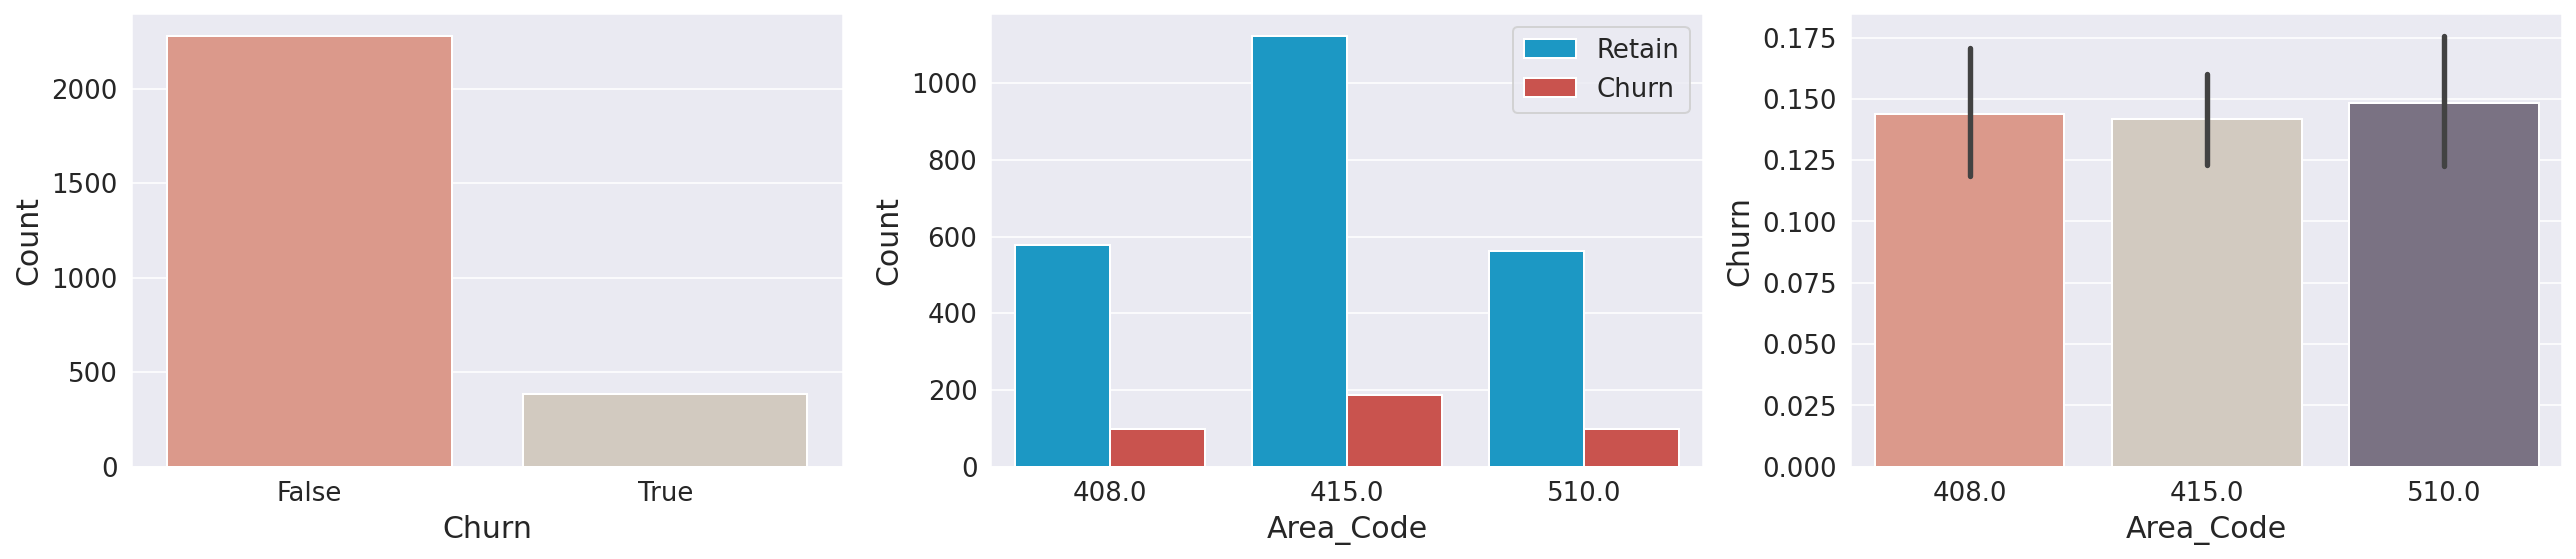

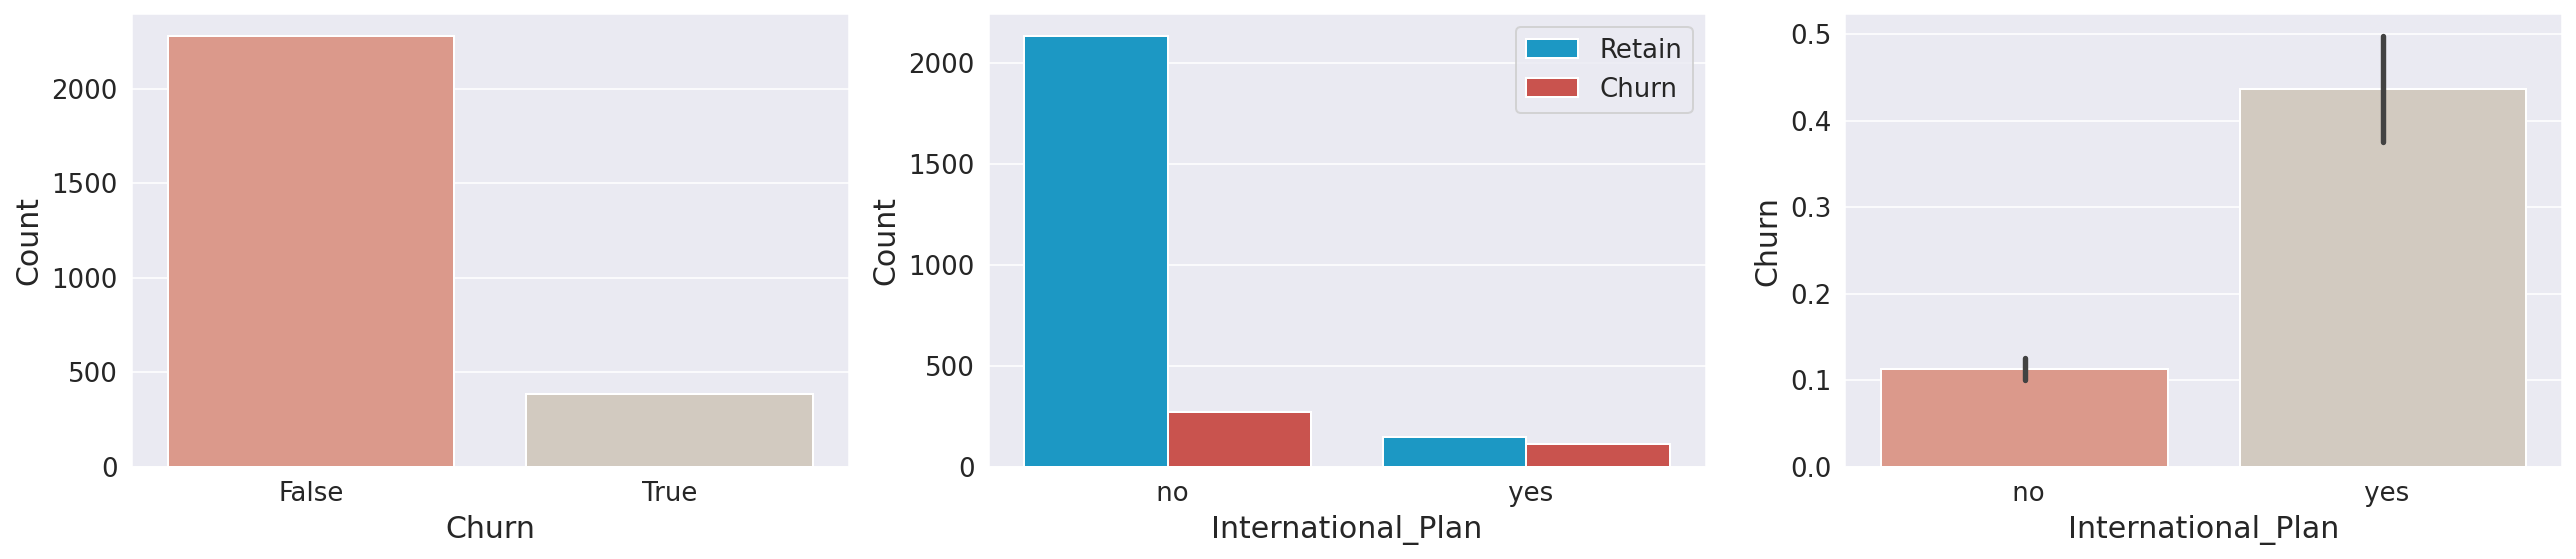

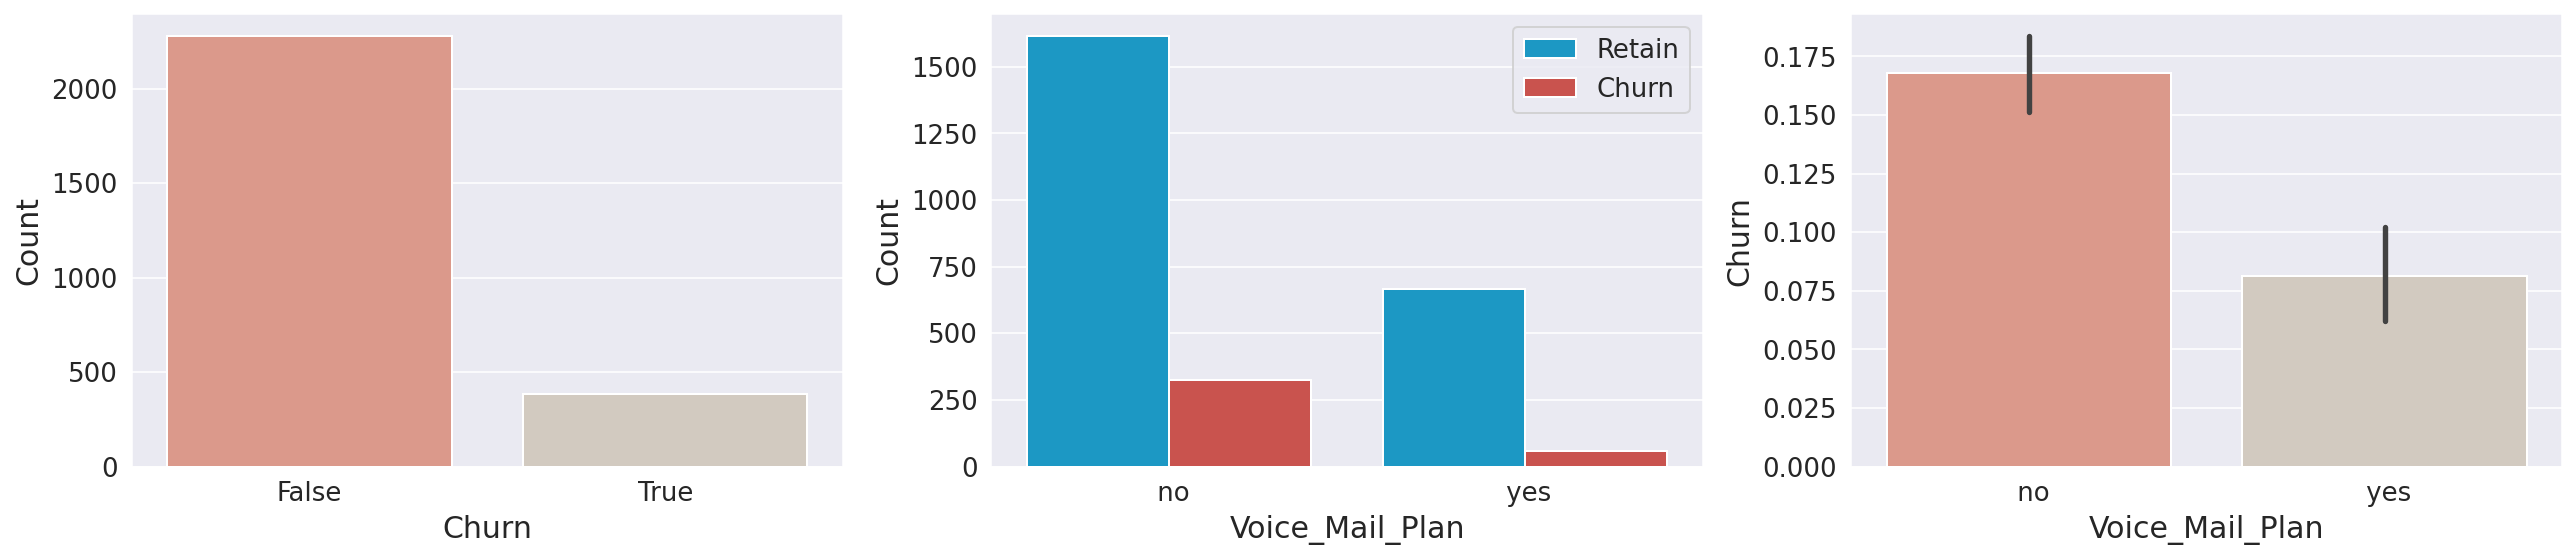

In [15]:
explor_categorical_plots(train_df,
                         feat_cols=['Area_Code','International_Plan','Voice_Mail_Plan'],
                         target_col='Churn',
                         target_col_mapname=['Retain','Churn']
                         )

In [16]:
numeric_cols = list(train_df.select_dtypes(include=[np.number]).columns)
print(numeric_cols)
numeric_cols.remove('Area_Code')

['Account_Length', 'Area_Code', 'Phone_No', 'No_Vmail_Messages', 'Total_Day_minutes', 'Total_Day_Calls', 'Total_Day_charge', 'Total_Eve_Minutes', 'Total_Eve_Calls', 'Total_Eve_Charge', 'Total_Night_Minutes', 'Total_Night_Calls', 'Total_Night_Charge', 'Total_Intl_Minutes', 'Total_Intl_Calls', 'Total_Intl_Charge', 'No_CS_Calls']


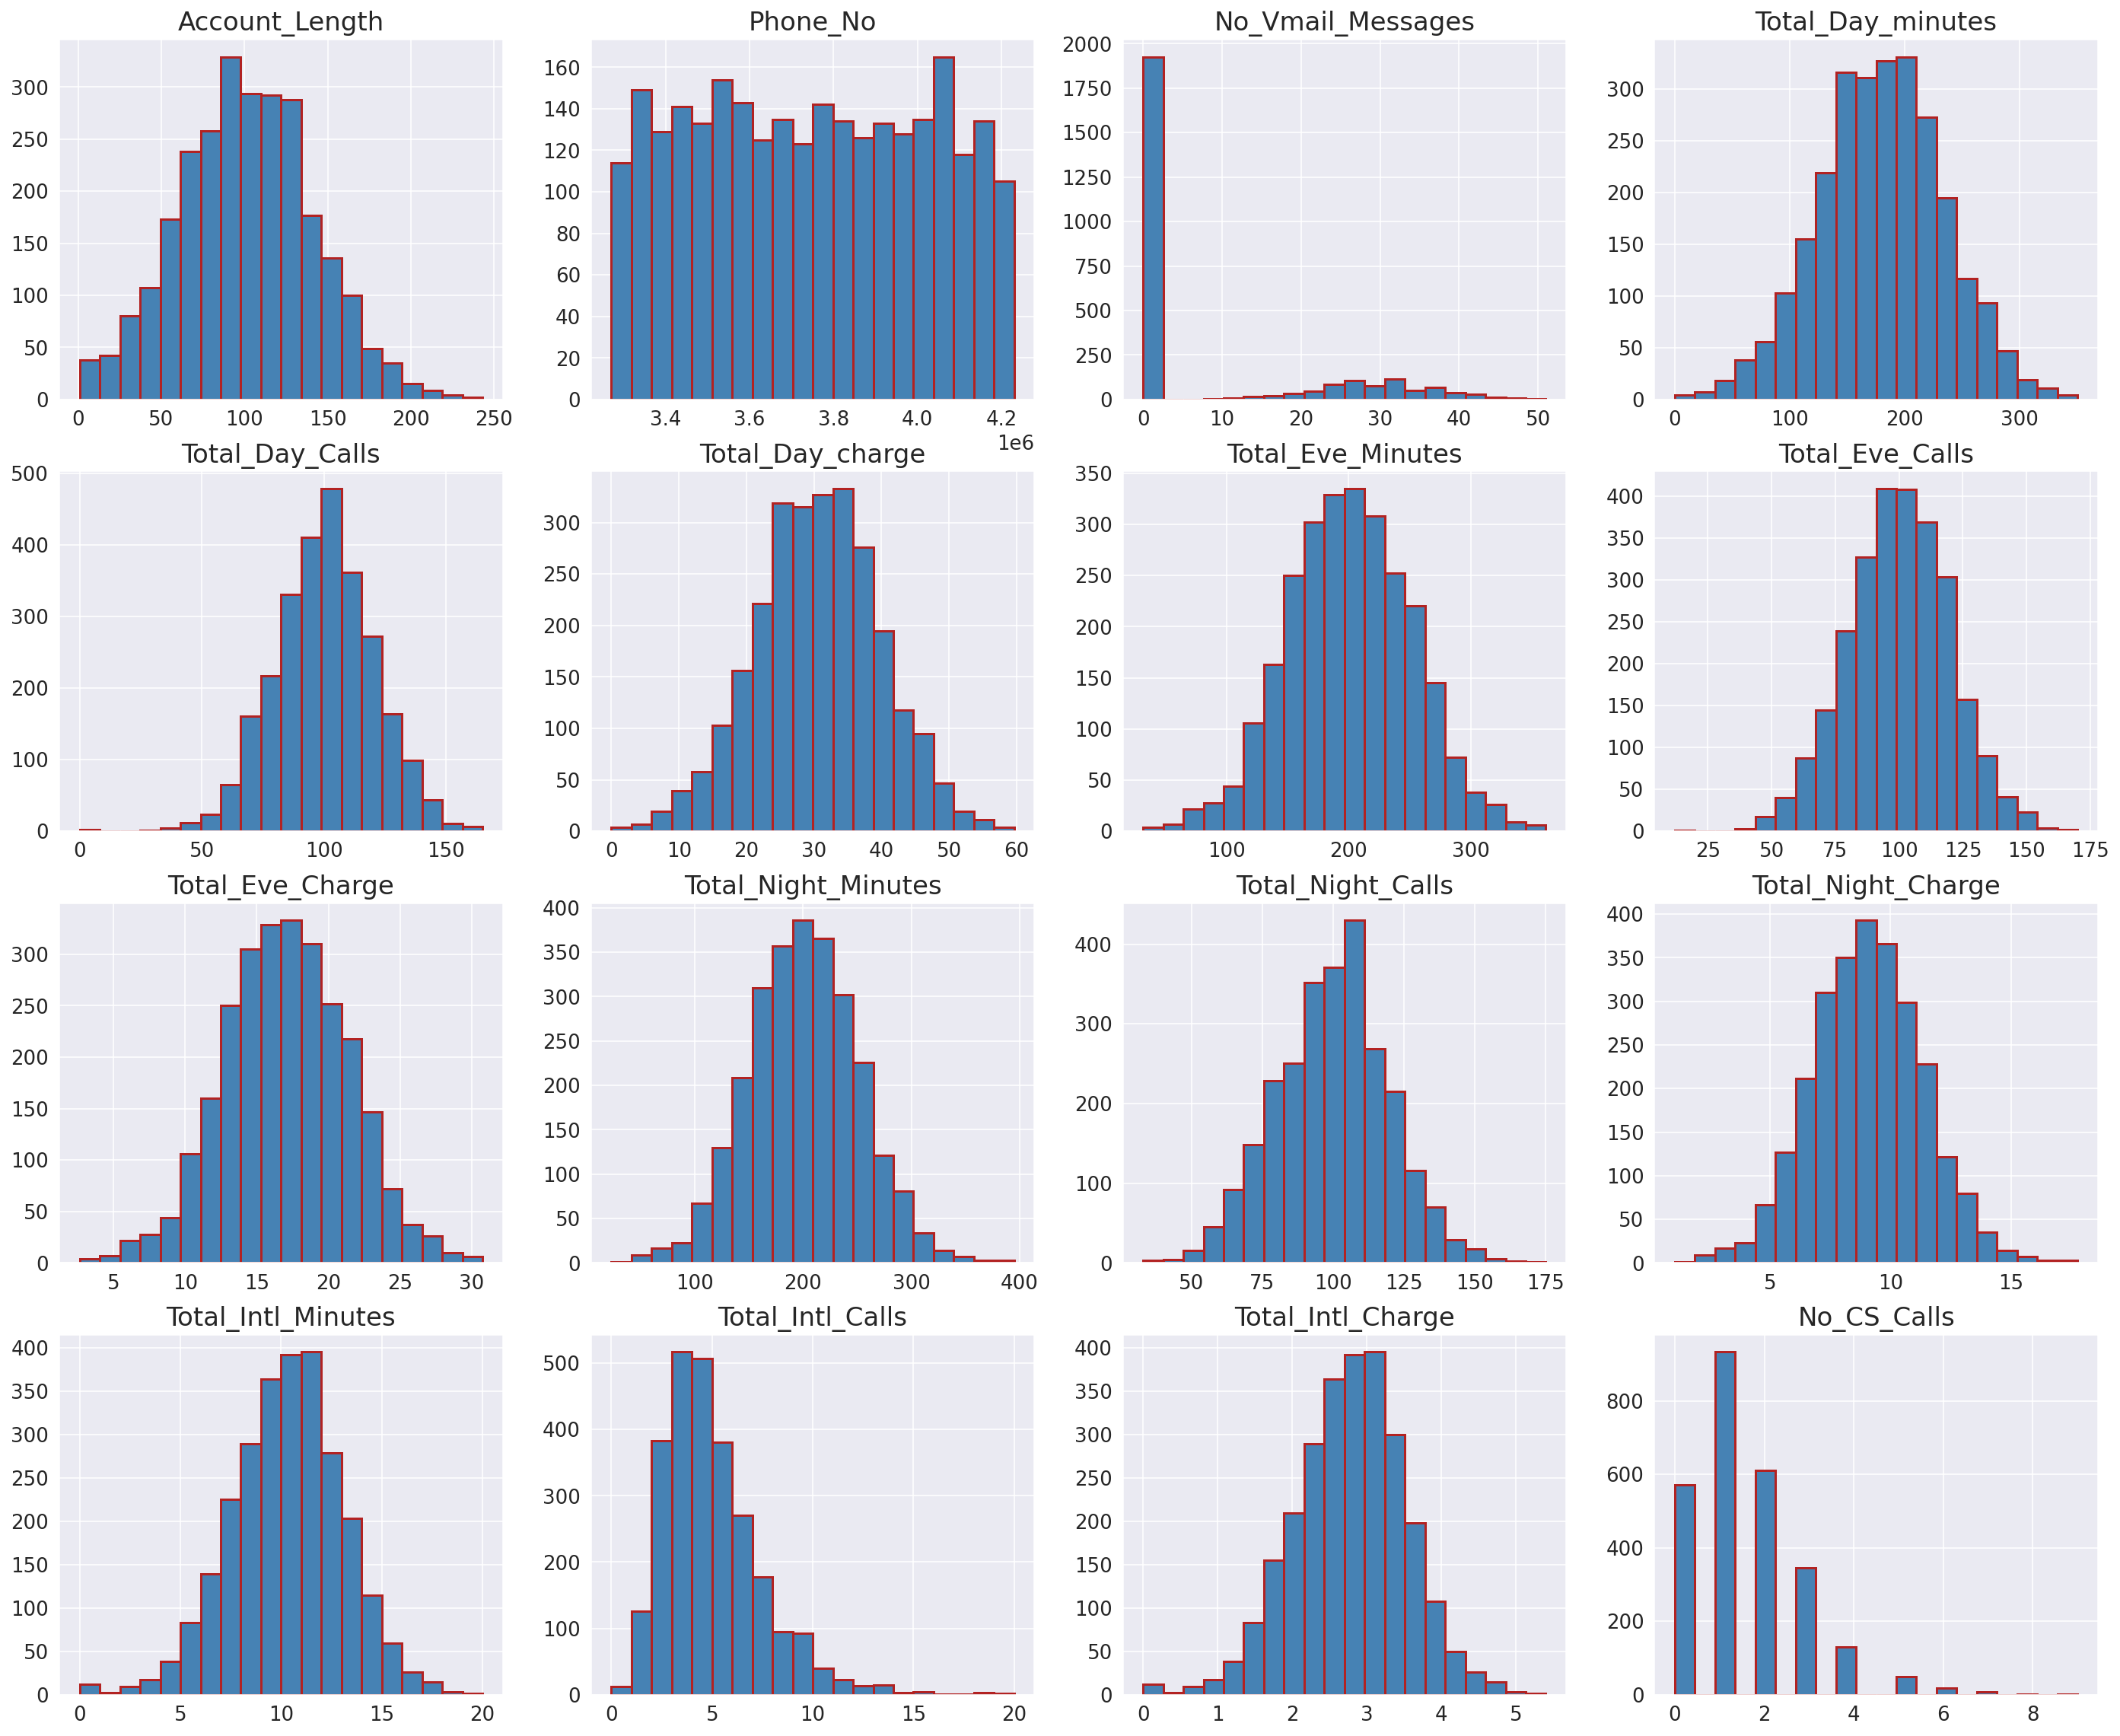

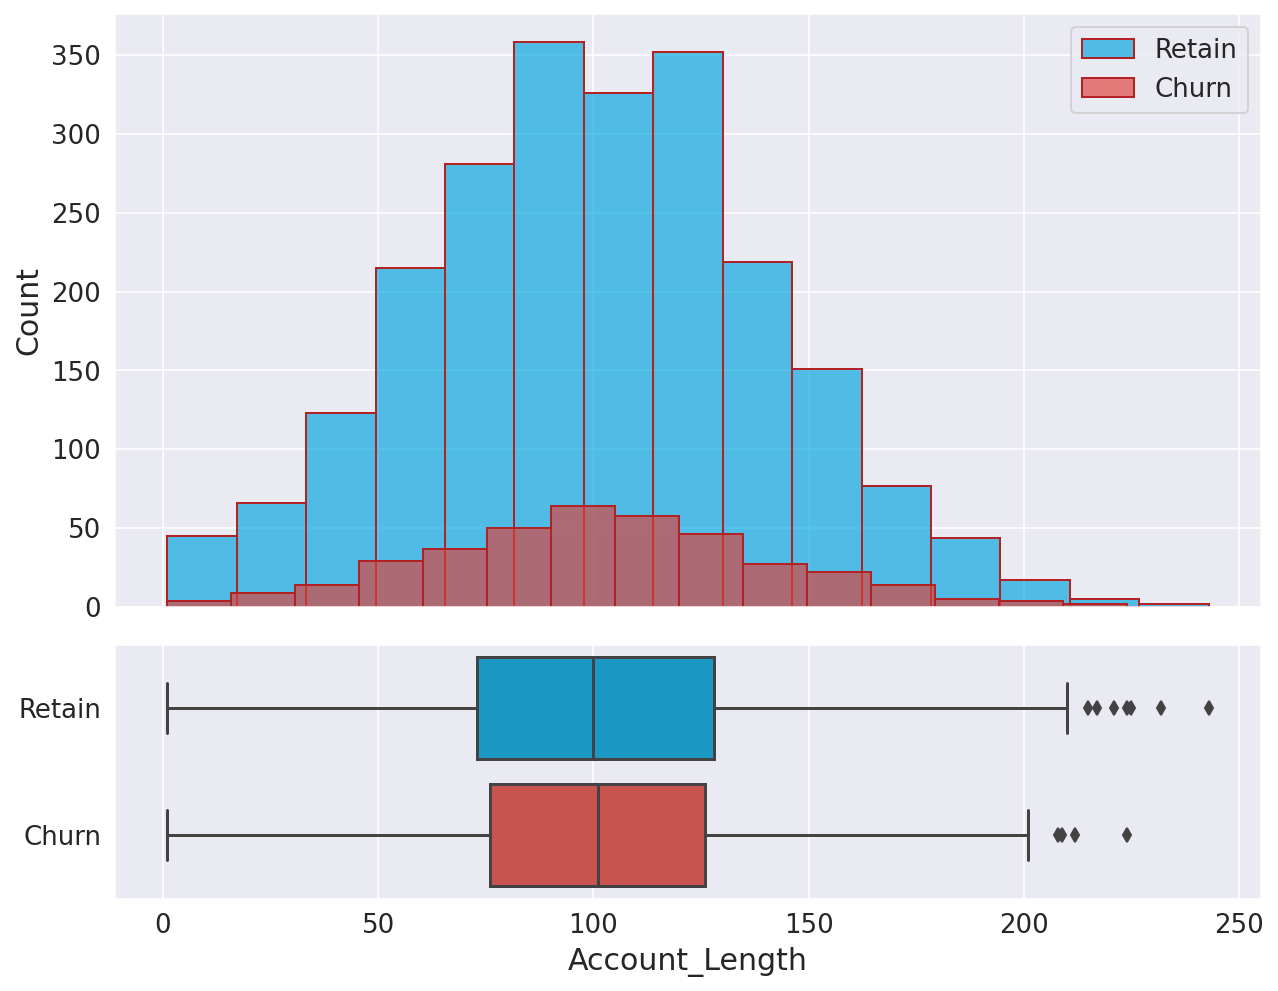

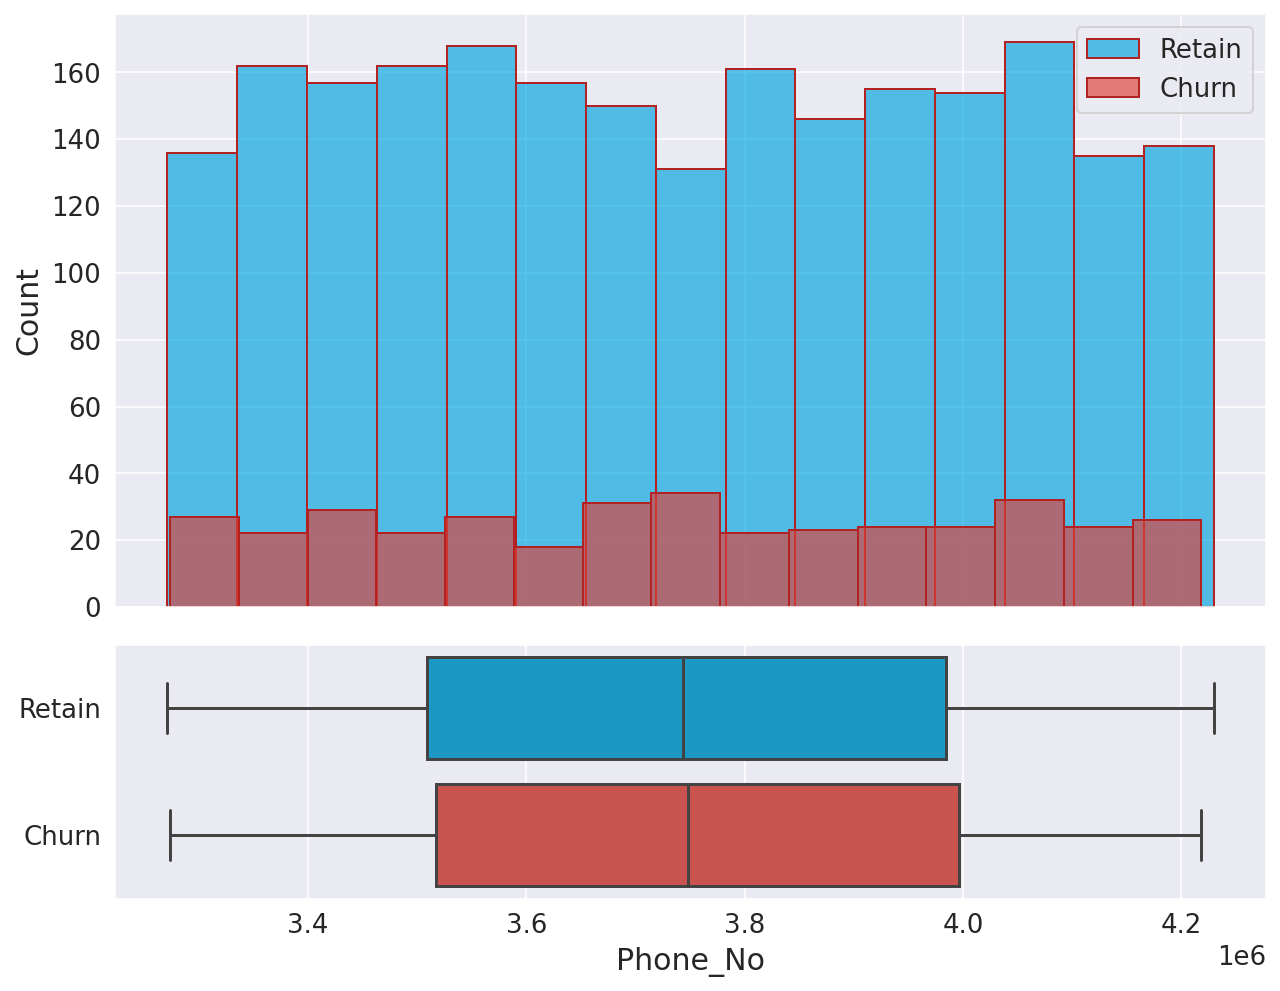

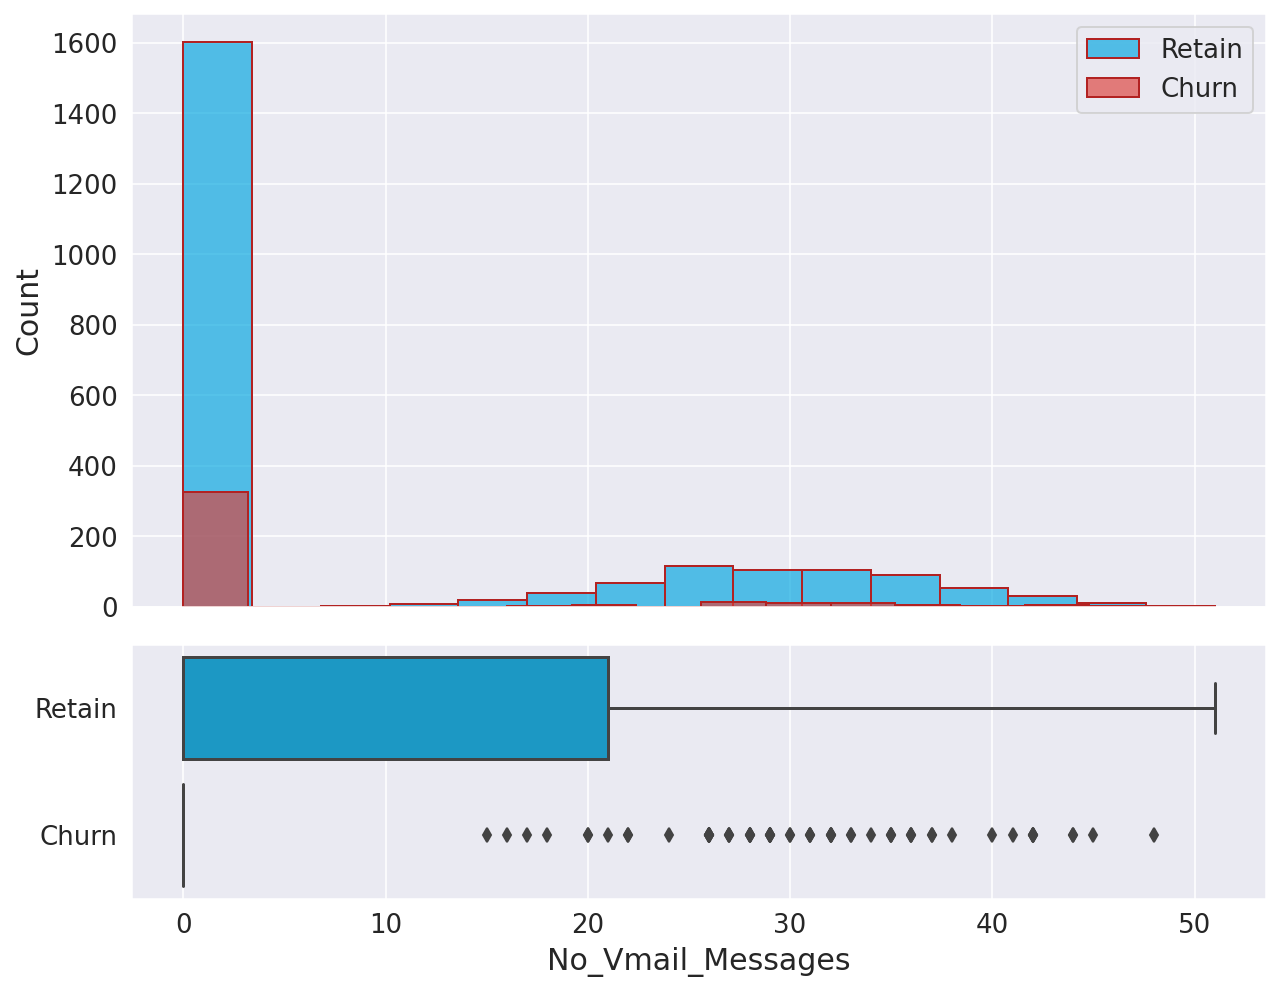

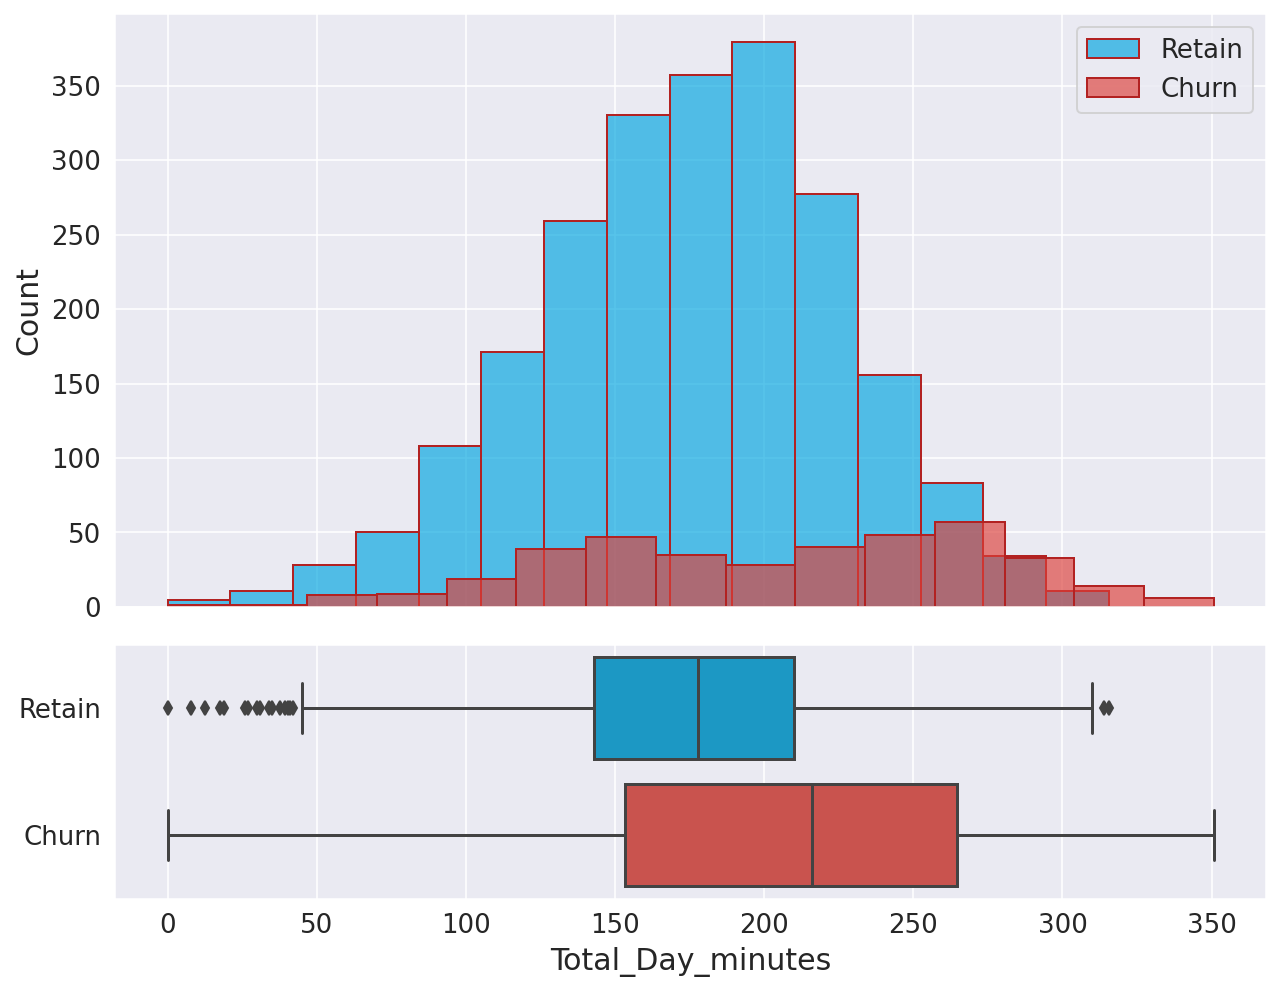

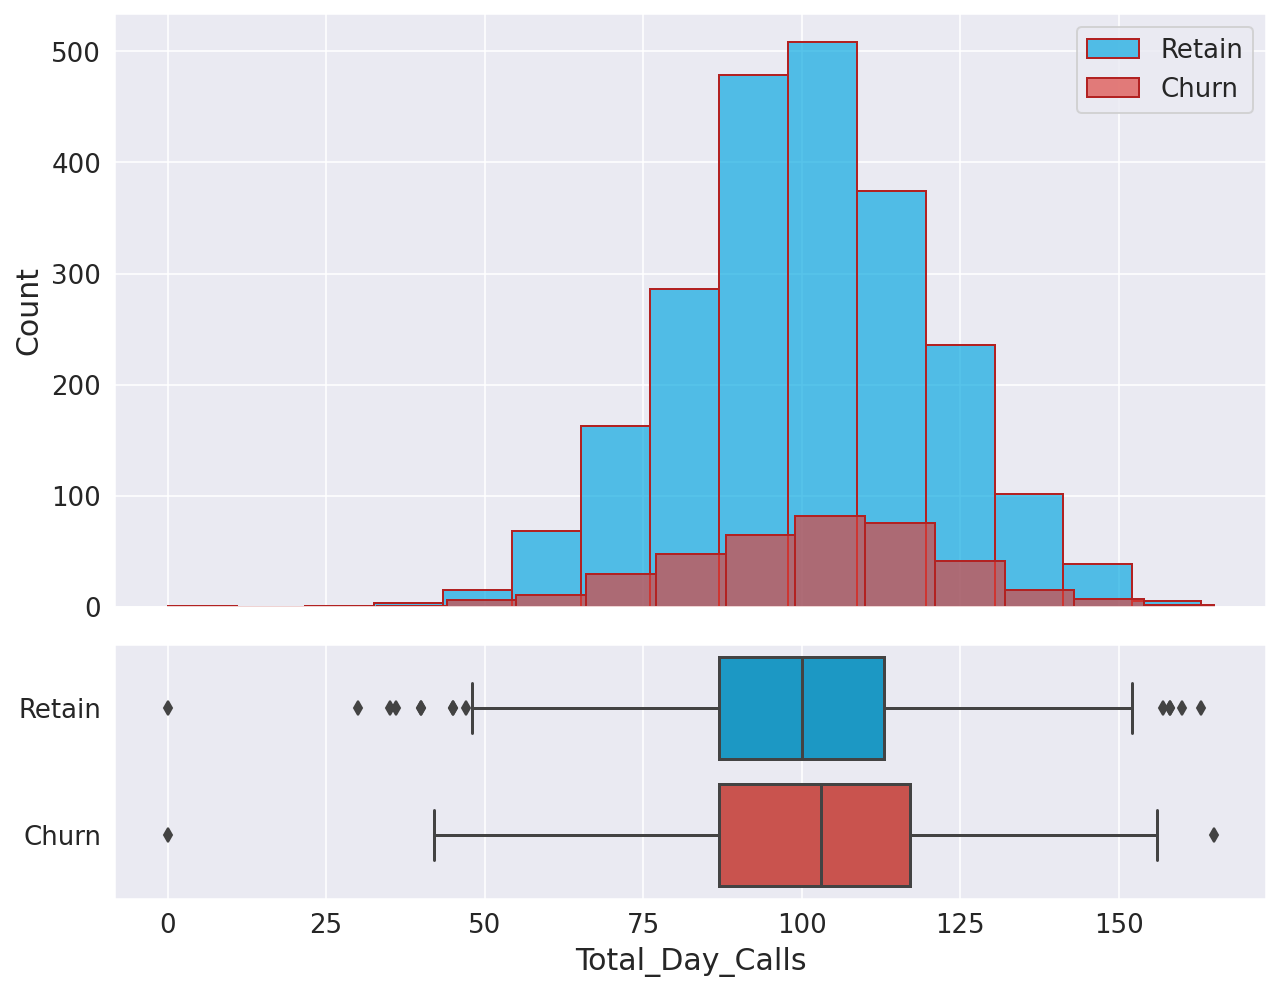

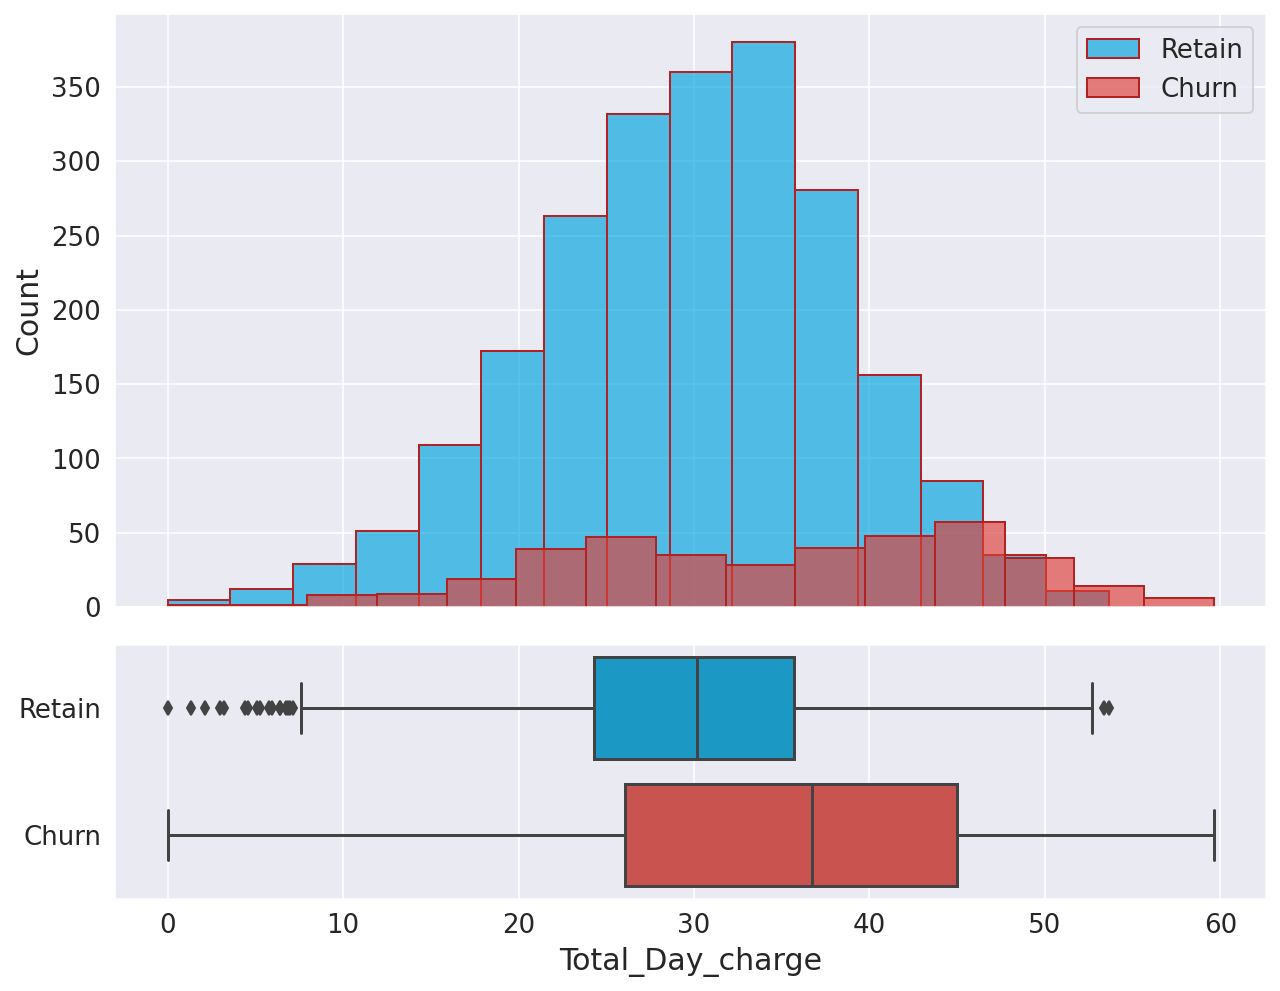

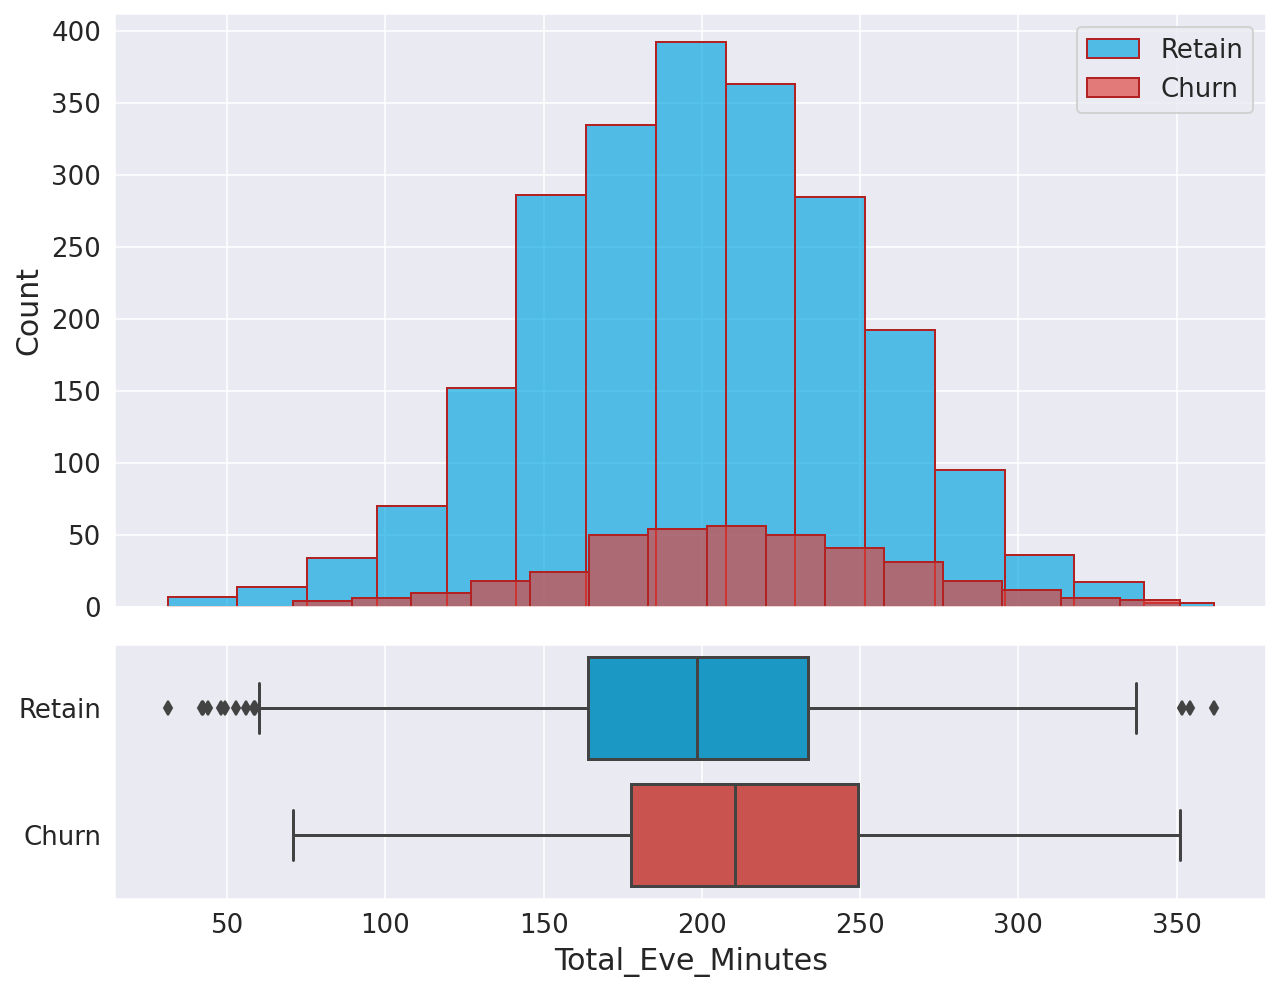

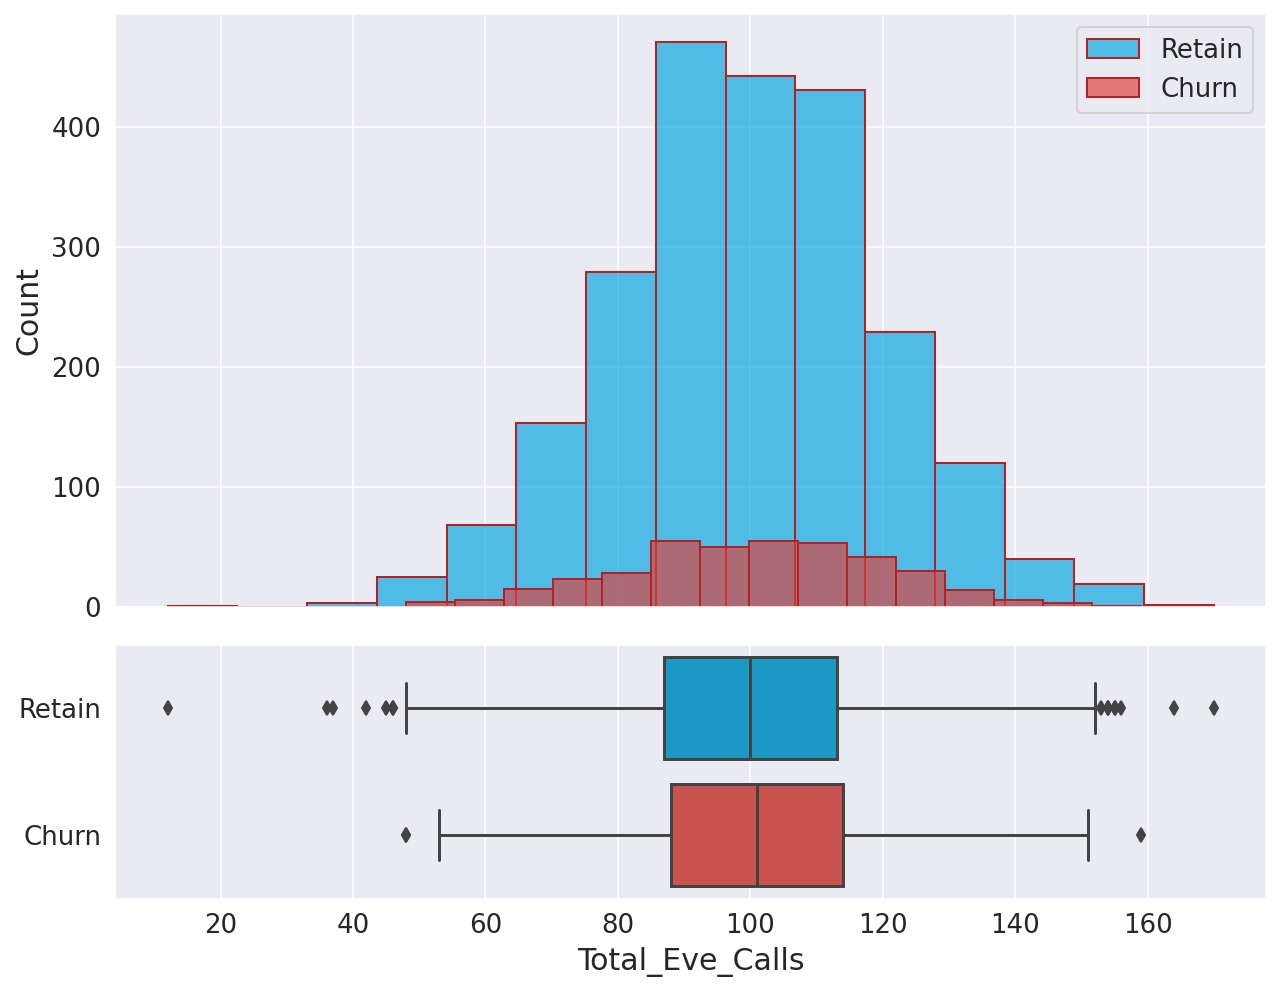

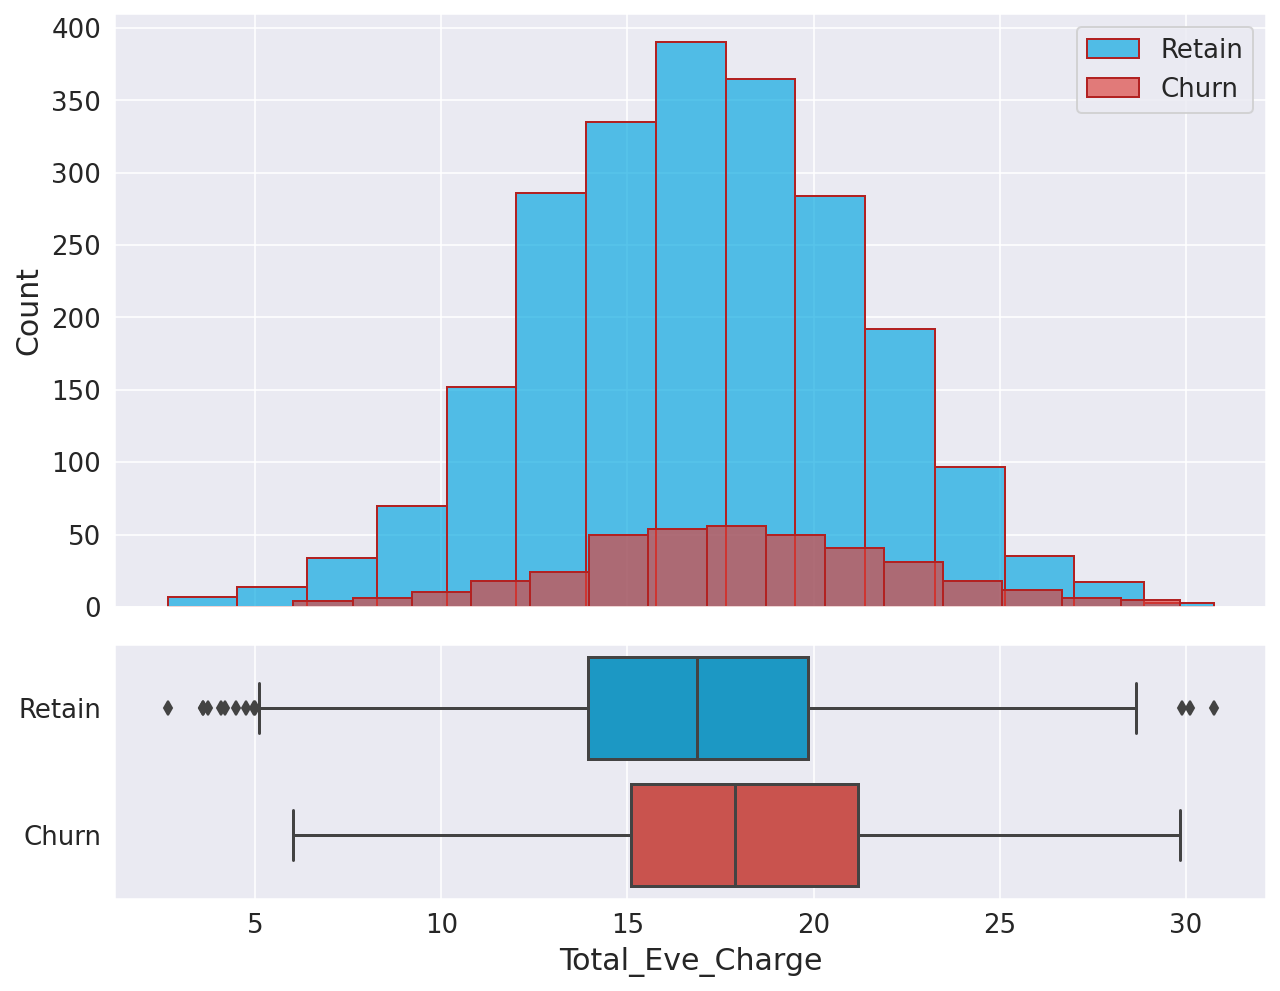

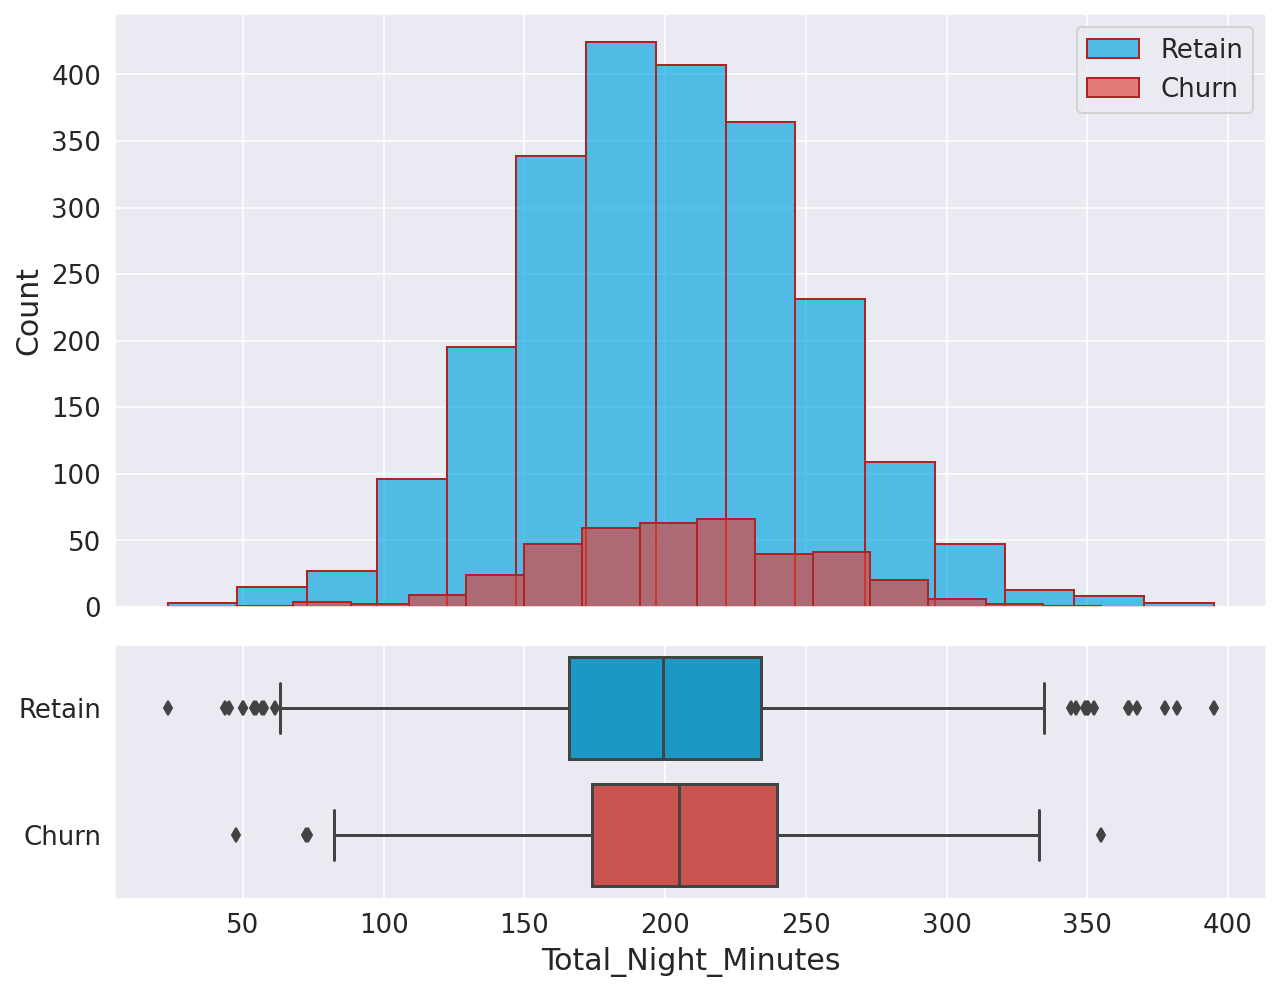

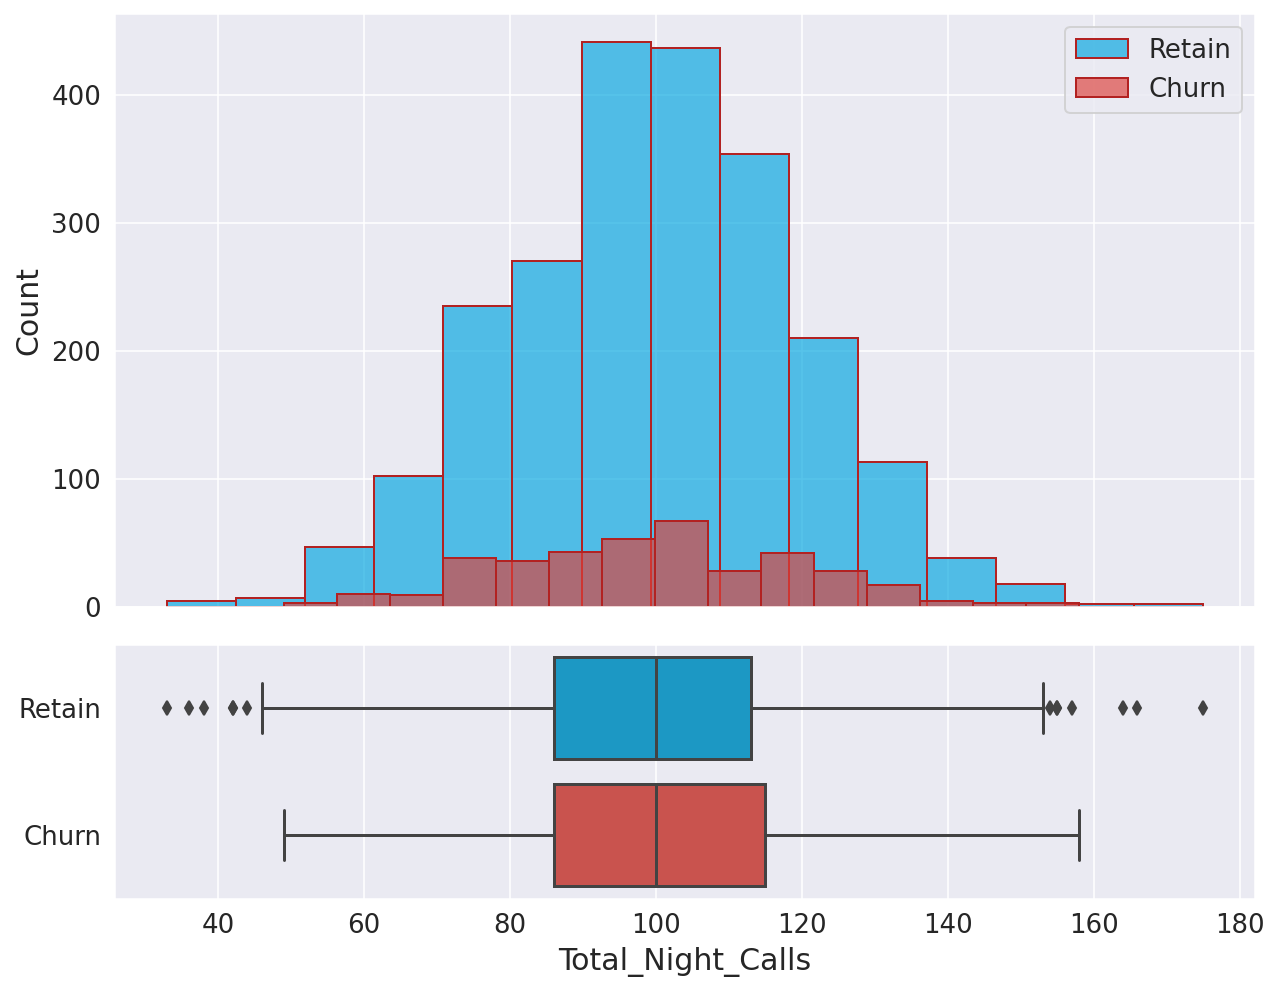

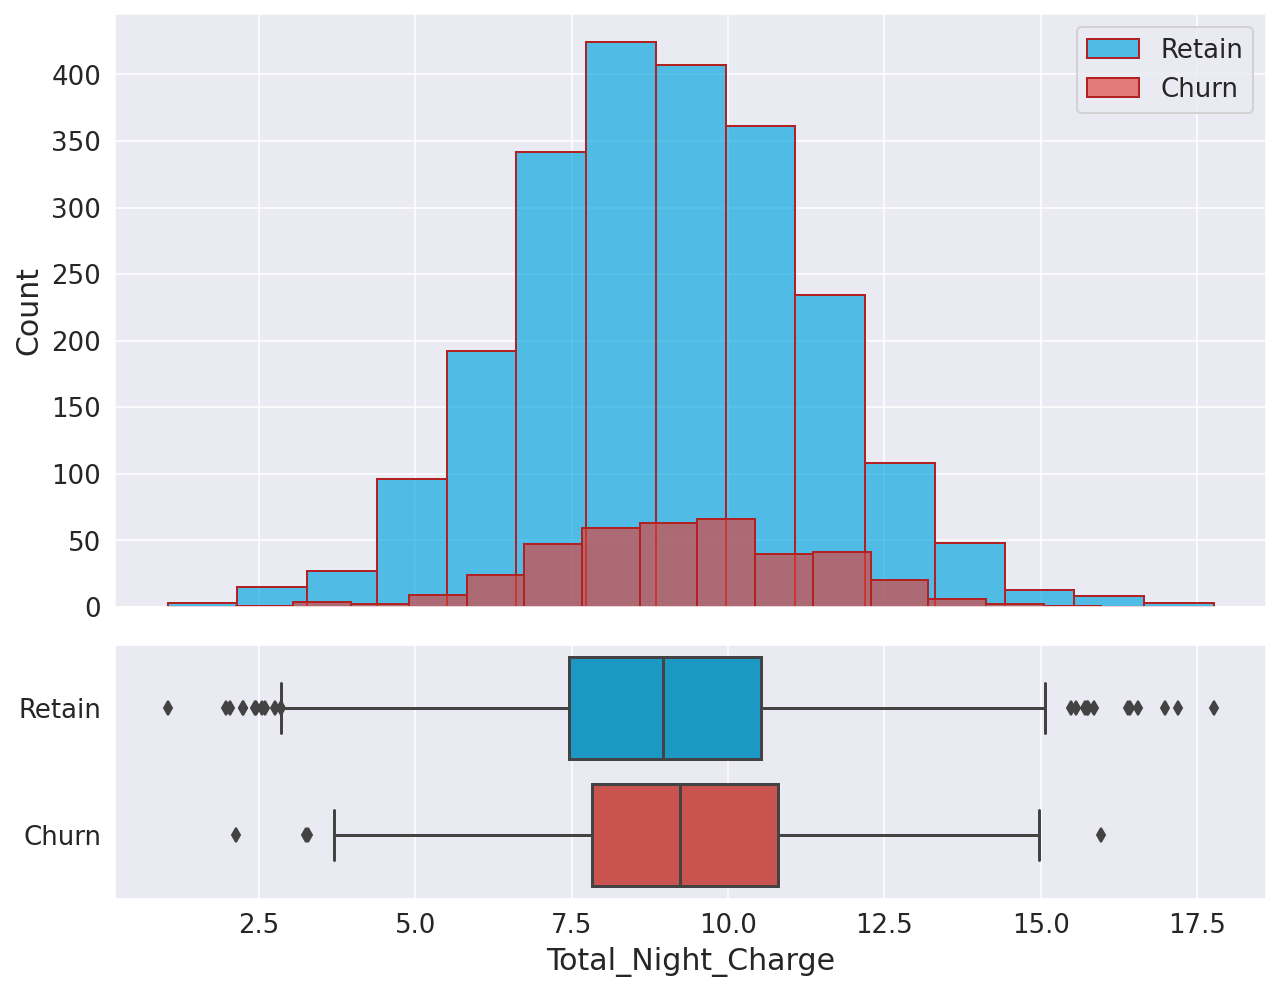

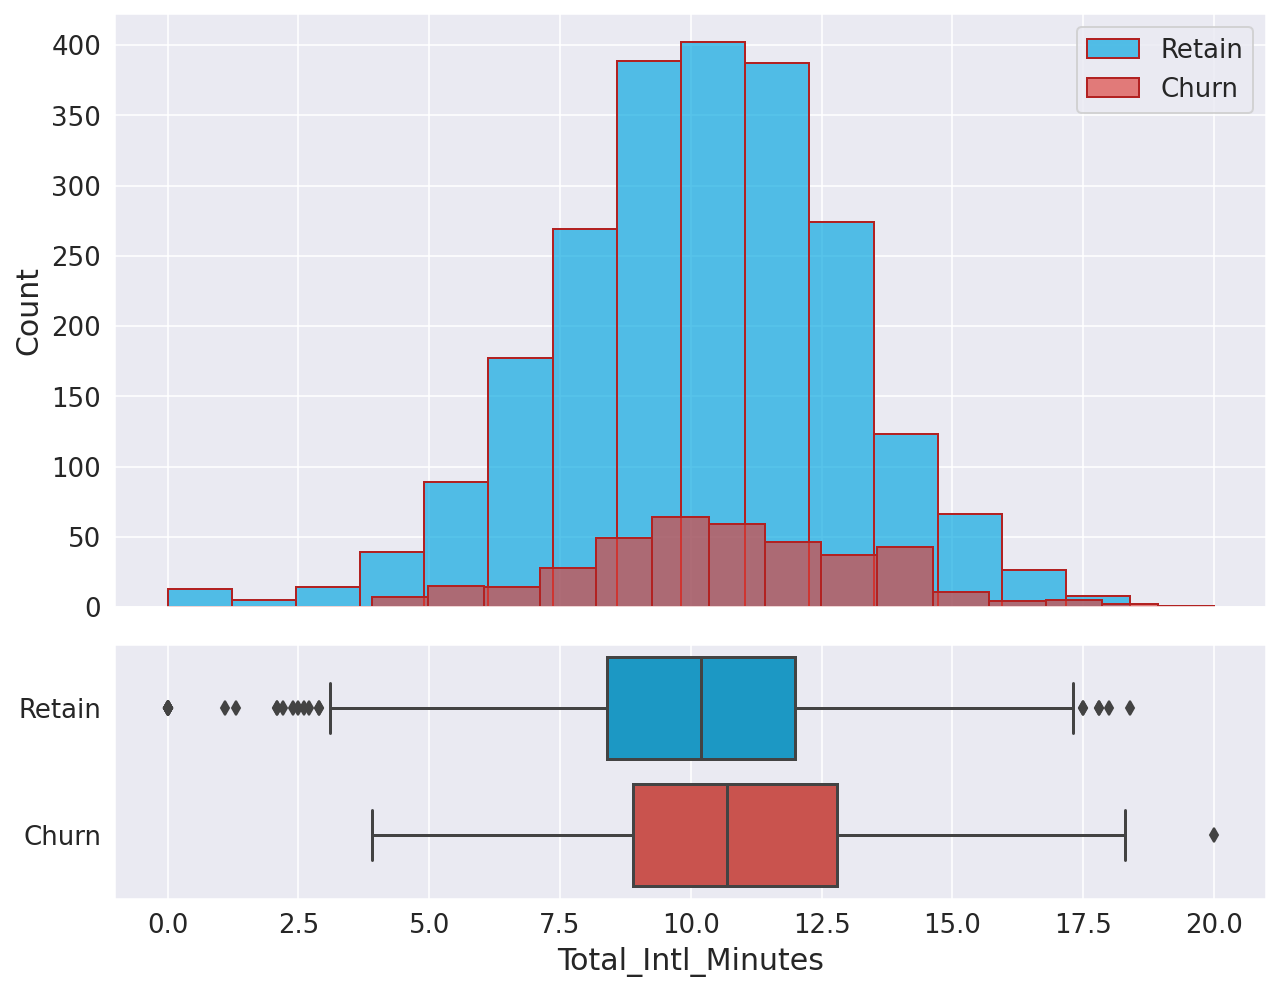

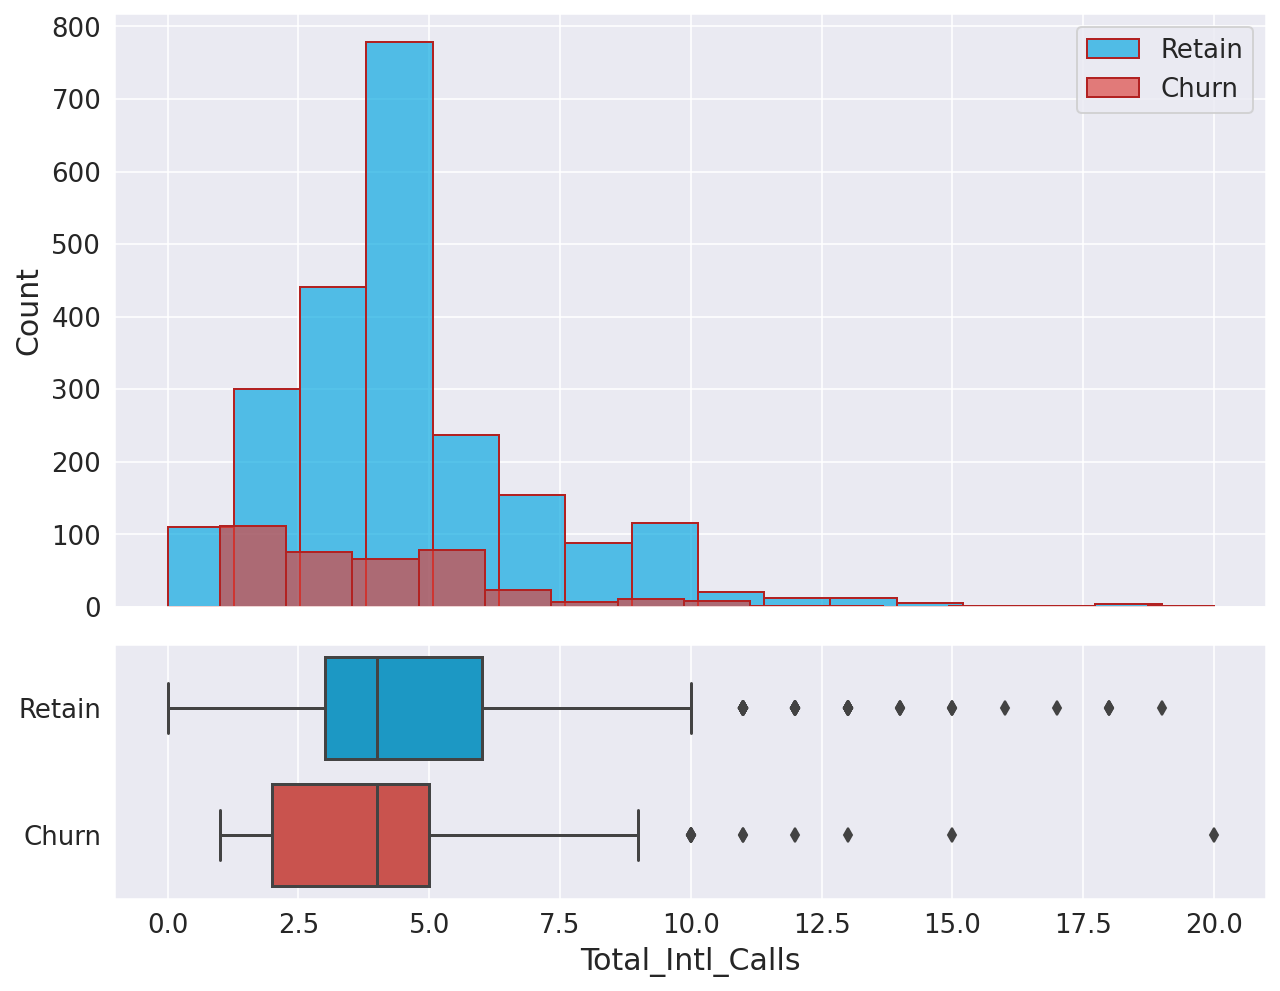

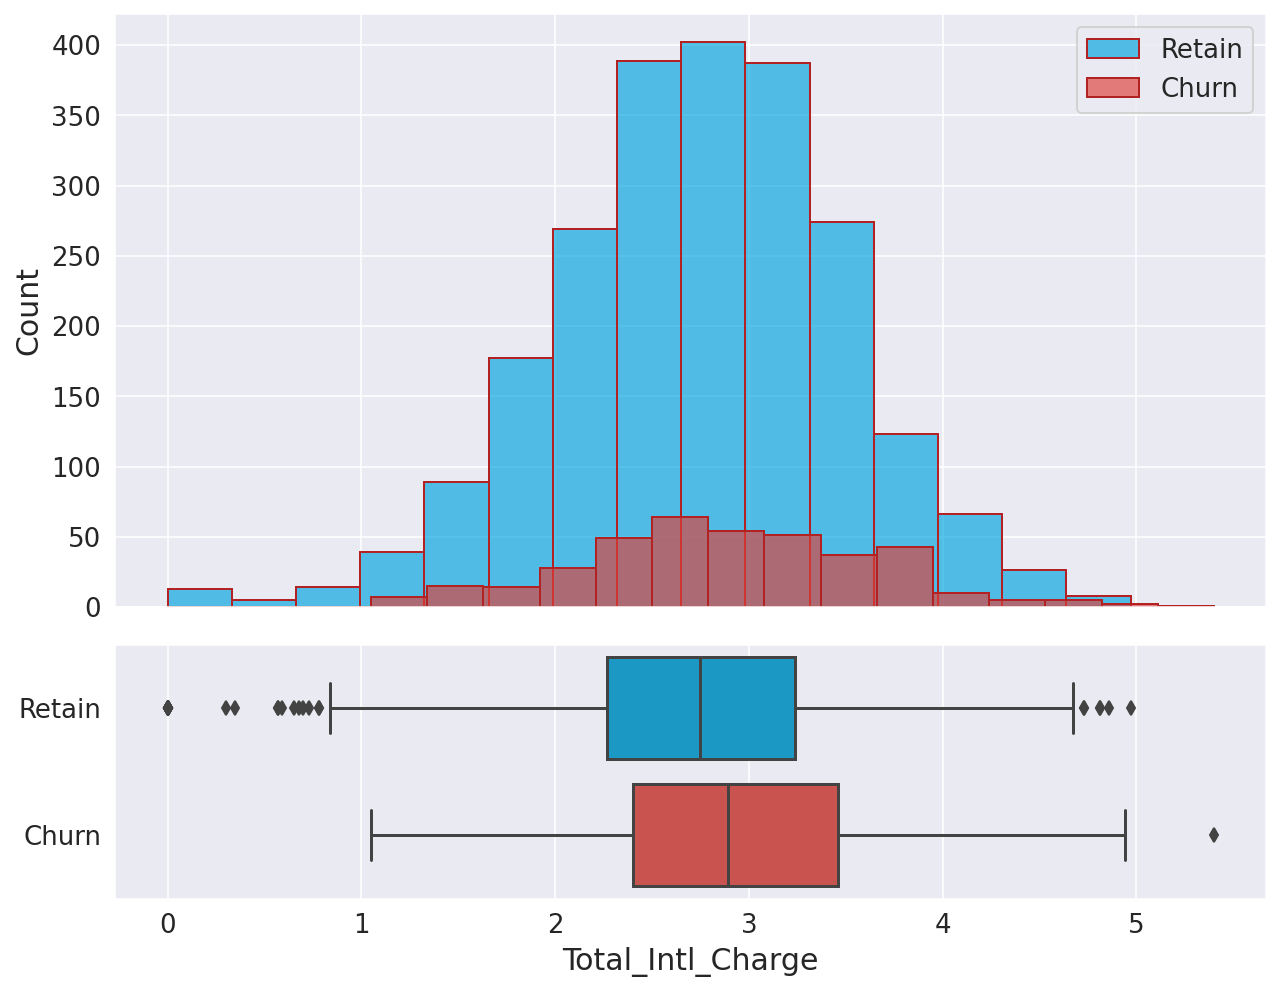

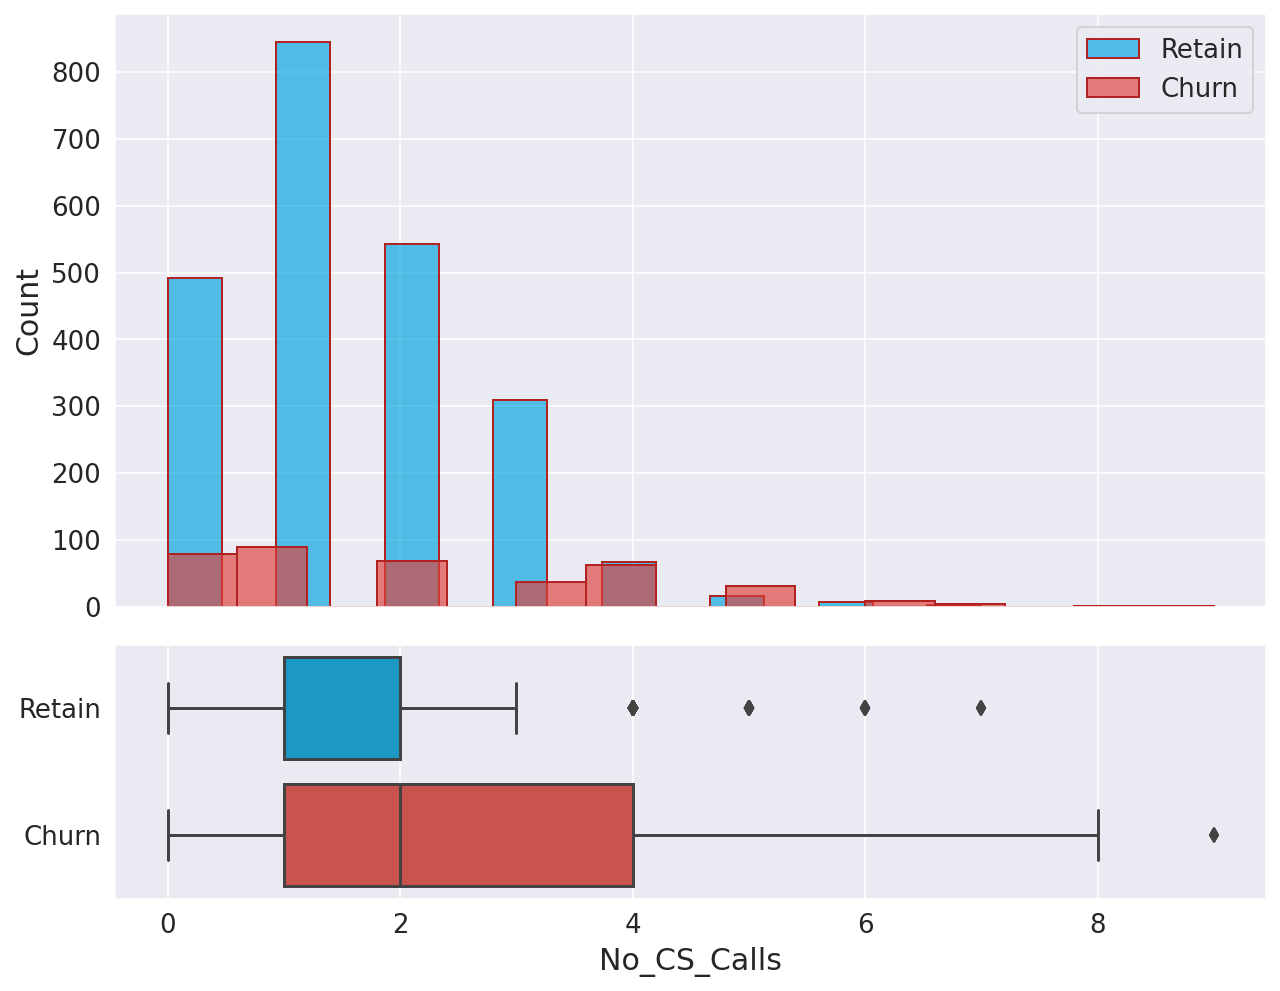

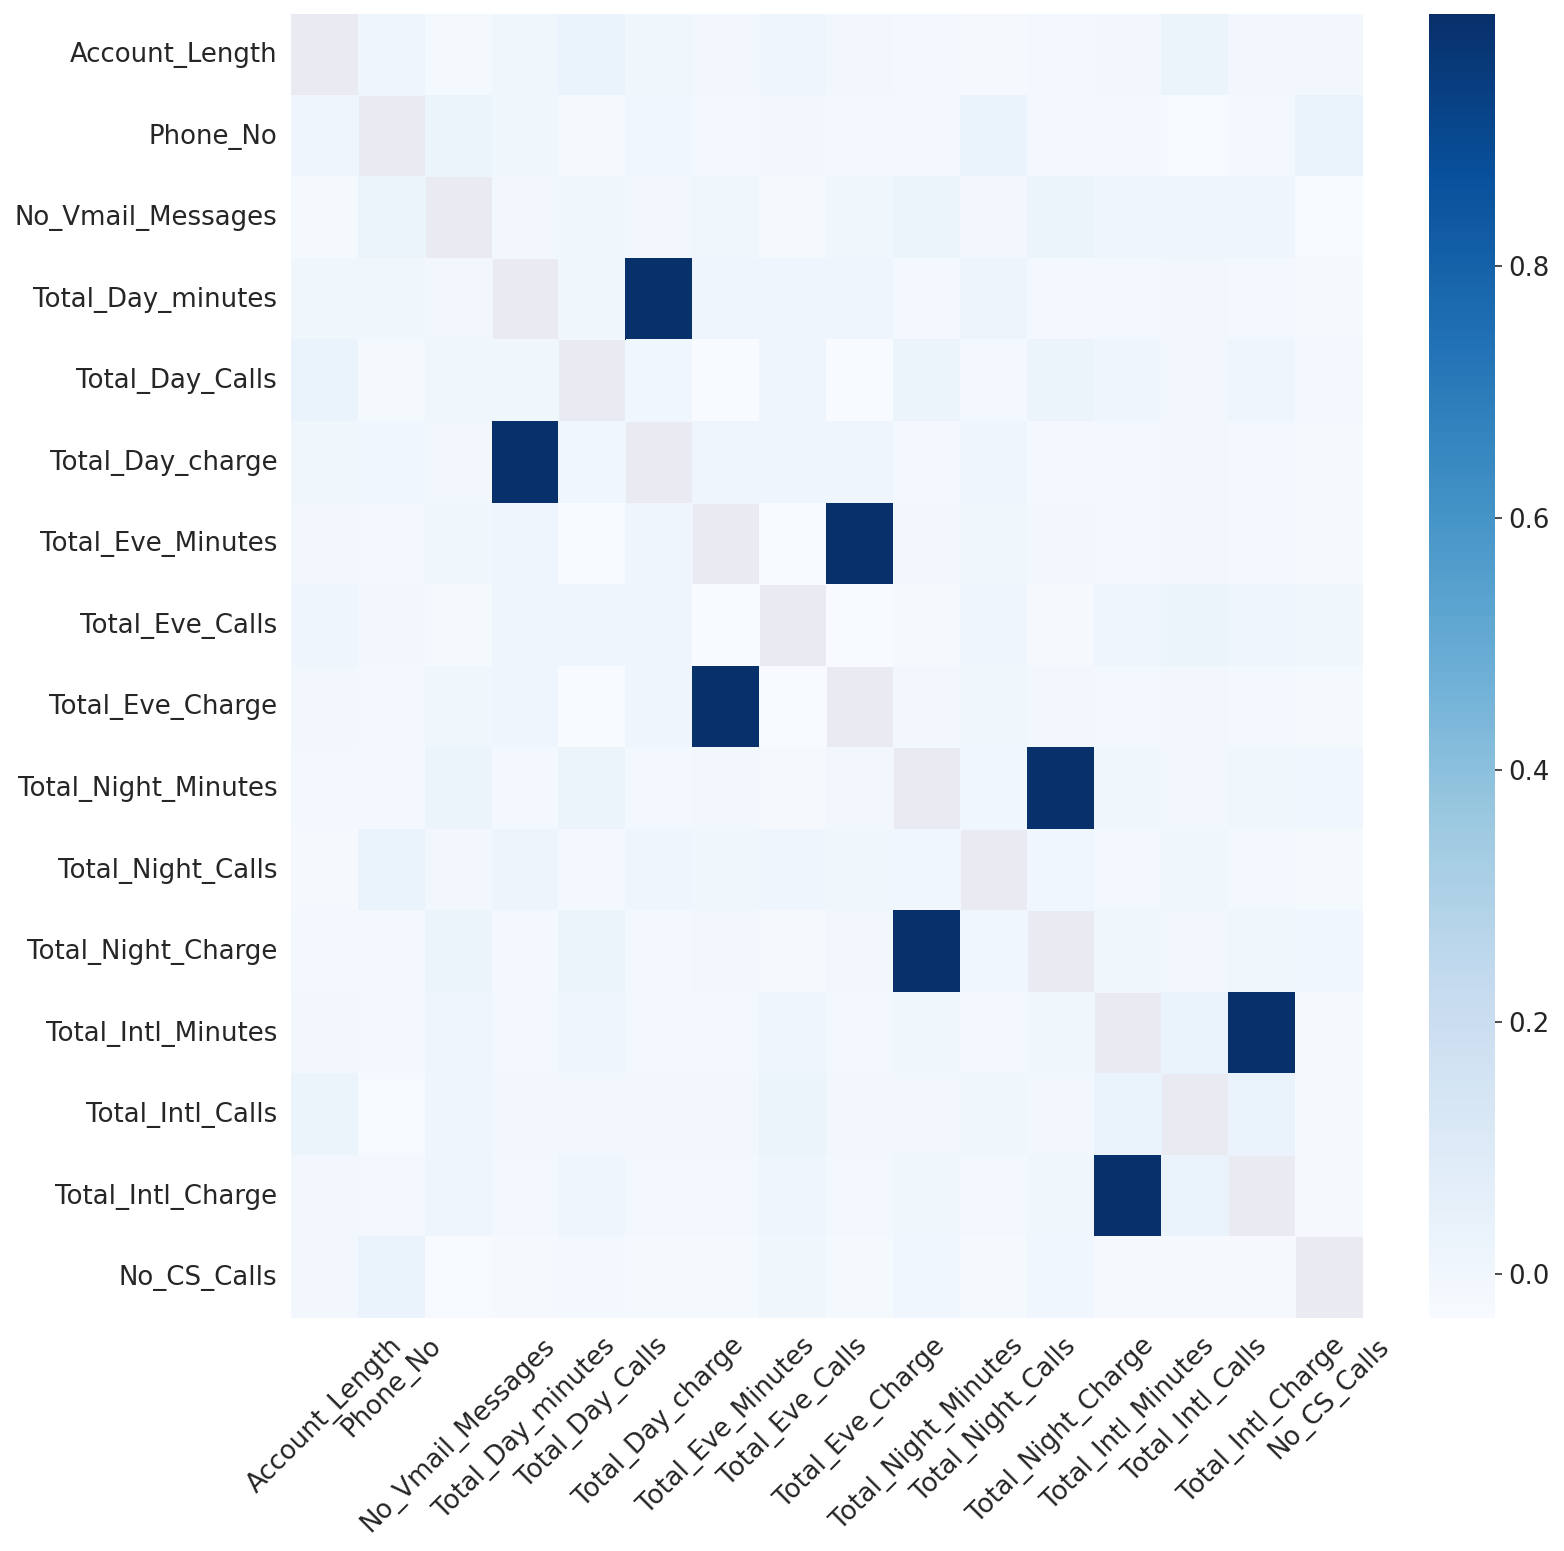

In [17]:
explor_continuous_plots(train_df,
                        numeric_cols,
                        target_col='Churn',
                        target_col_mapname=['Retain','Churn'],
                        plot_cols=4)

In [18]:
#### Data preprocess

In [19]:
preprocess_dict = {}
train_df,fill_na_dict =fill_na(train_df,
                                 category_cols        =['State','Area_Code'],
                                 cont_cols            =['No_Vmail_Messages','Total_Day_minutes'],
                                 fill_category_value  ='unknown',
                              )
print(fill_na_dict)
preprocess_dict['fill_na_dict'] = fill_na_dict

{'category': {'State': 'unknown', 'Area_Code': 'unknown'}, 'continous': {'No_Vmail_Messages': 8.011342155009451, 'Total_Day_minutes': 179.8038577912253}}


In [20]:
train_df,target_encode_dict = target_encoder(train_df,['State'],target_col='Churn',post_fix='_TE')
preprocess_dict['target_encode_dict']= target_encode_dict

In [21]:
train_df['Area_Code']=train_df['Area_Code'].astype(str)
train_df,one_hot_enc_dict = one_hot_encoder(train_df,feat_cols=['Area_Code'])
preprocess_dict['one_hot_enc_dict']= one_hot_enc_dict

In [22]:
train_df,label_enc_dict = label_encoder(train_df,feat_cols=['International_Plan','Voice_Mail_Plan'],postfix='_LE')
preprocess_dict['label_enc_dict']= label_enc_dict

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
train_df.head()

,State,Account_Length,Area_Code,Phone_No,International_Plan,Voice_Mail_Plan,No_Vmail_Messages,Total_Day_minutes,Total_Day_Calls,Total_Day_charge,Total_Eve_Minutes,Total_Eve_Calls,Total_Eve_Charge,Total_Night_Minutes,Total_Night_Calls,Total_Night_Charge,Total_Intl_Minutes,Total_Intl_Calls,Total_Intl_Charge,No_CS_Calls,Churn,State_TE,Area_Code_408.0,Area_Code_415.0,Area_Code_510.0,Area_Code_unknown,International_Plan_LE,Voice_Mail_Plan_LE
1680,GA,107,510.0,3852683,no,no,0.0,194.5,97,33.07,186.3,131,15.84,178.3,106,8.02,12.7,1,3.43,2,False,0.152174,0.0,0.0,1.0,0.0,0,0
81,OR,116,415.0,3317425,yes,no,0.0,215.4,104,36.62,204.8,79,17.41,278.5,109,12.53,12.6,5,3.40,3,False,0.152542,0.0,1.0,0.0,0.0,1,0
151,NE,117,415.0,3543436,no,no,0.0,102.8,119,17.48,206.7,91,17.57,299.0,105,13.46,10.1,7,2.73,1,False,0.090909,0.0,1.0,0.0,0.0,0,0
774,OR,80,415.0,3918087,no,no,0.0,161.1,99,27.39,198.8,81,16.90,228.4,116,10.28,10.6,4,2.86,1,False,0.152542,0.0,1.0,0.0,0.0,0,0
790,AZ,92,415.0,4169522,yes,yes,45.0,281.1,88,47.79,198.0,103,16.83,94.3,76,4.24,7.5,3,2.03,0,False,0.083333,0.0,1.0,0.0,0.0,1,1


In [24]:
train_df.columns

Index(['State', 'Account_Length', 'Area_Code', 'Phone_No',
       'International_Plan', 'Voice_Mail_Plan', 'No_Vmail_Messages',
       'Total_Day_minutes', 'Total_Day_Calls', 'Total_Day_charge',
       'Total_Eve_Minutes', 'Total_Eve_Calls', 'Total_Eve_Charge',
       'Total_Night_Minutes', 'Total_Night_Calls', 'Total_Night_Charge',
       'Total_Intl_Minutes', 'Total_Intl_Calls', 'Total_Intl_Charge',
       'No_CS_Calls', 'Churn', 'State_TE', 'Area_Code_408.0',
       'Area_Code_415.0', 'Area_Code_510.0', 'Area_Code_unknown',
       'International_Plan_LE', 'Voice_Mail_Plan_LE'],
      dtype='object')

In [25]:
feats= ['State_TE', 'Area_Code_408.0','Area_Code_415.0', 'Area_Code_510.0', 'Area_Code_unknown',
       'International_Plan_LE', 'Voice_Mail_Plan_LE',
       'Account_Length', 'Phone_No', 'No_Vmail_Messages',
       'Total_Day_minutes', 'Total_Day_Calls', 'Total_Day_charge','Total_Eve_Minutes', 'Total_Eve_Calls', 'Total_Eve_Charge',
       'Total_Night_Minutes', 'Total_Night_Calls', 'Total_Night_Charge', 'Total_Intl_Minutes', 'Total_Intl_Calls', 'Total_Intl_Charge', 'No_CS_Calls'
       ]

In [102]:
#### Train model 
#### This step is to get optiaml parameters and feature importance to select the approraite features in the final model

In [26]:
def parameter_search(X,
                     y,
                     estimator,
                     param_grid,
                     ):
  best_score = np.inf
  for g in ParameterGrid(param_grid):
    estimator.set_params(**g)
    estimator.fit(X,y)
    # save if best
    pred_train = np.argmax(estimator.oob_decision_function_,axis=1)
    oob_score = log_loss(y,pred_train)
    #print(oob_score,g)
    if oob_score < best_score:
        best_score = oob_score
        best_grid = g
  estimator.set_params(**best_grid)
  estimator.fit(X,y)
  print(f"OOB best: {best_score:.4f} and para is {best_grid}") 
  return estimator

In [27]:
rf = RandomForestClassifier(random_state=42,oob_score=True,class_weight='balanced',n_jobs=-1,bootstrap=True)
param_grid = {
    'n_estimators': [100,300],
    'criterion': ['entropy', 'gini'],
    'max_depth': [4,8],
    'max_features': [0.5, 0.8],
    'min_samples_leaf': [5,11],
    'min_samples_split': [5,11,19],
}
best_rf_clf = parameter_search(train_df[feats].values, 
                               train_df['Churn'].values,estimator=rf,param_grid=param_grid)             

OOB best: 1.5417 and para is {'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300}


accuracy 0.9733683420855214, precision 0.9337016574585635, recall is 0.8779220779220779
roc auc is 0.9337001884568742


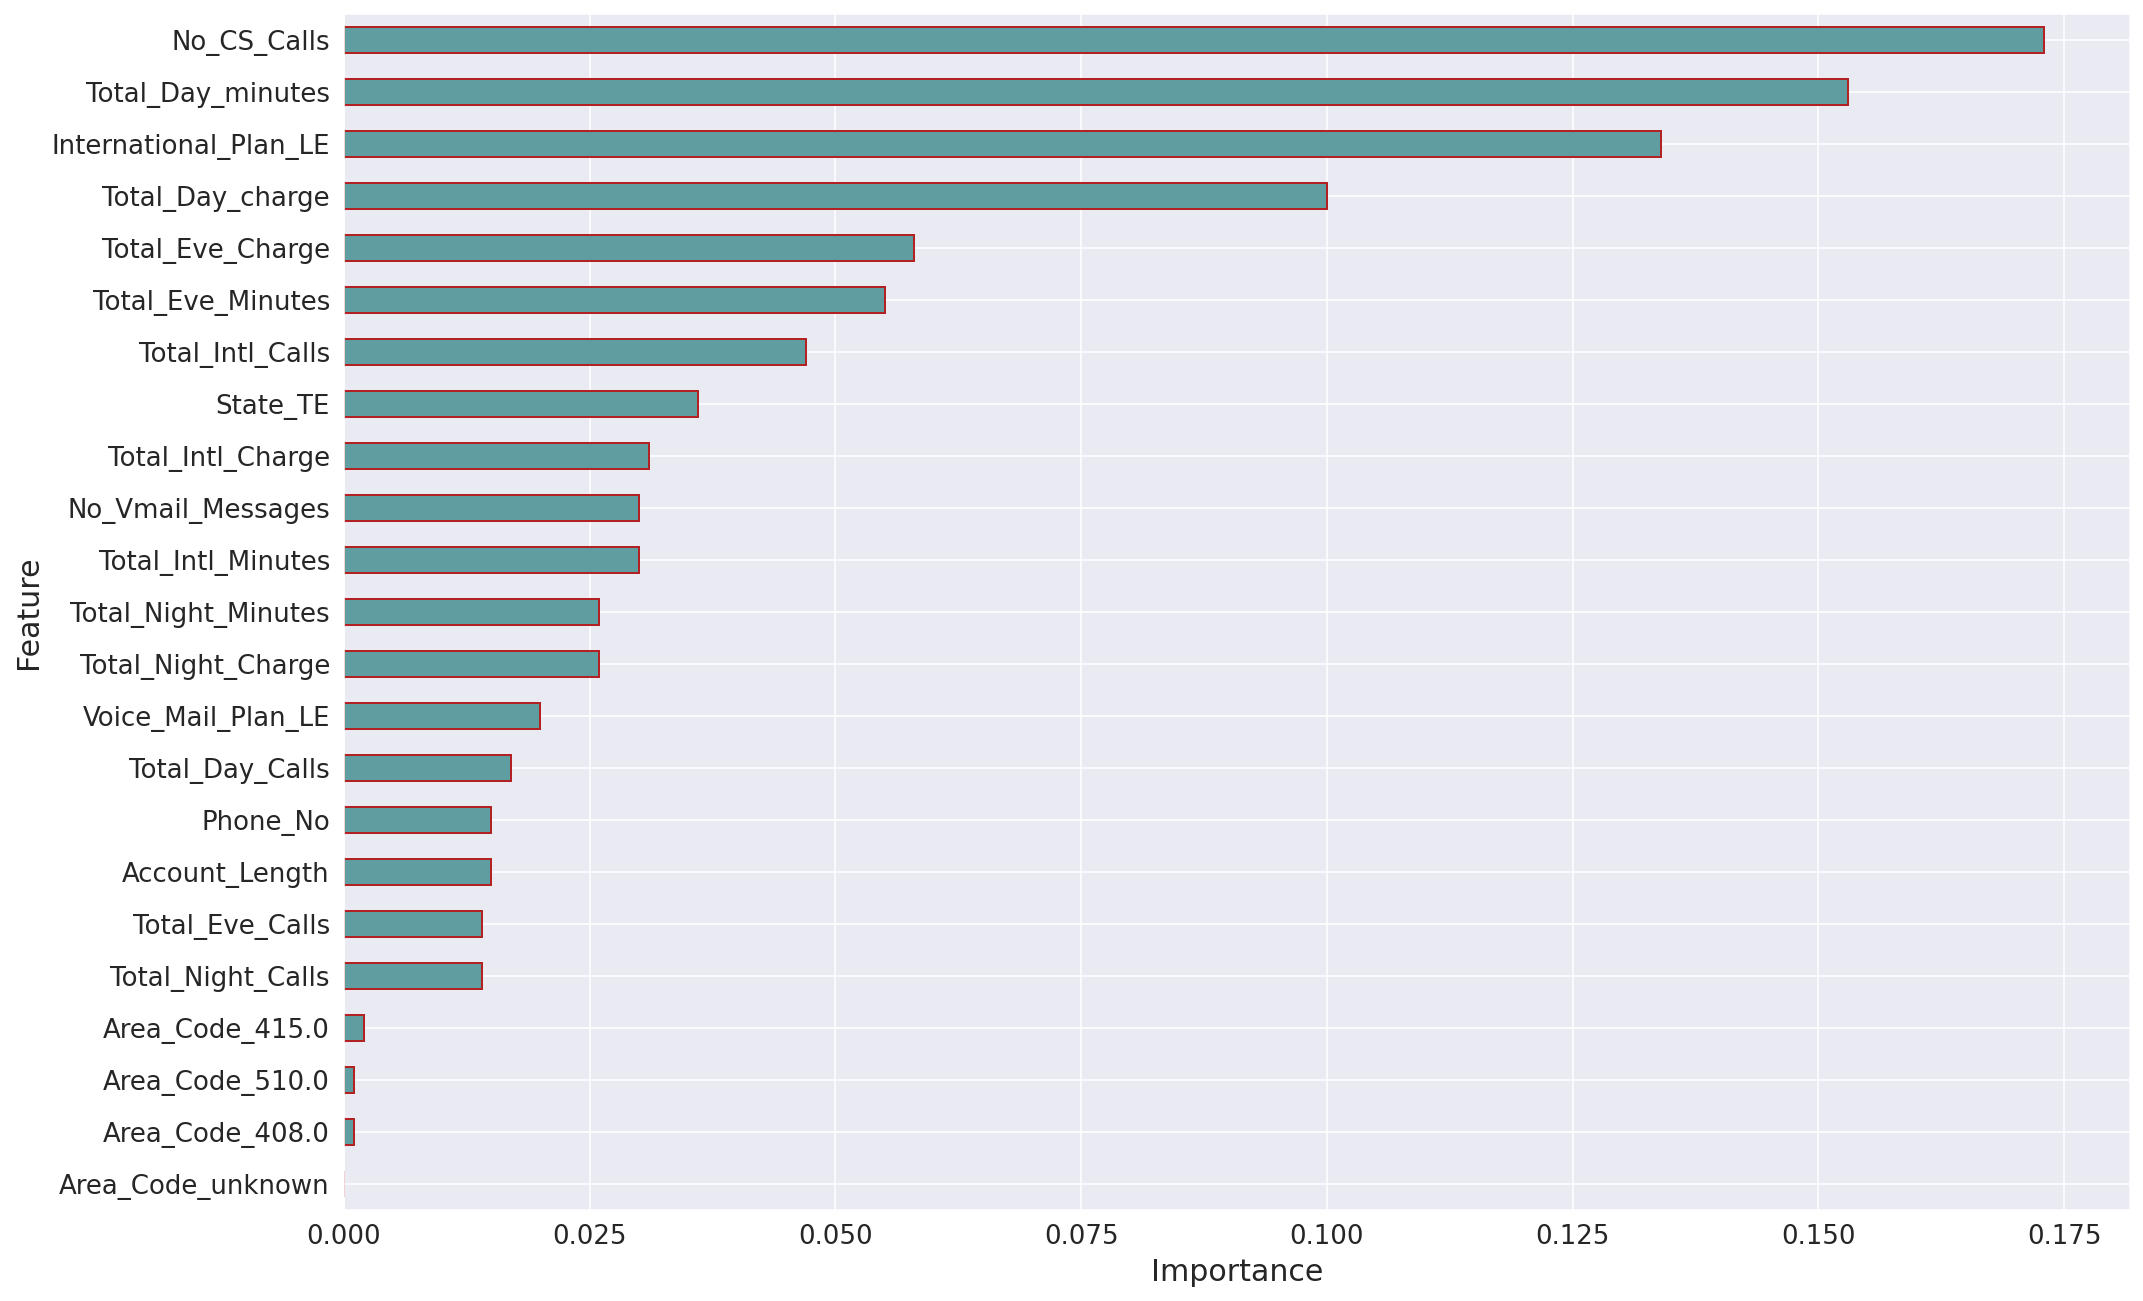

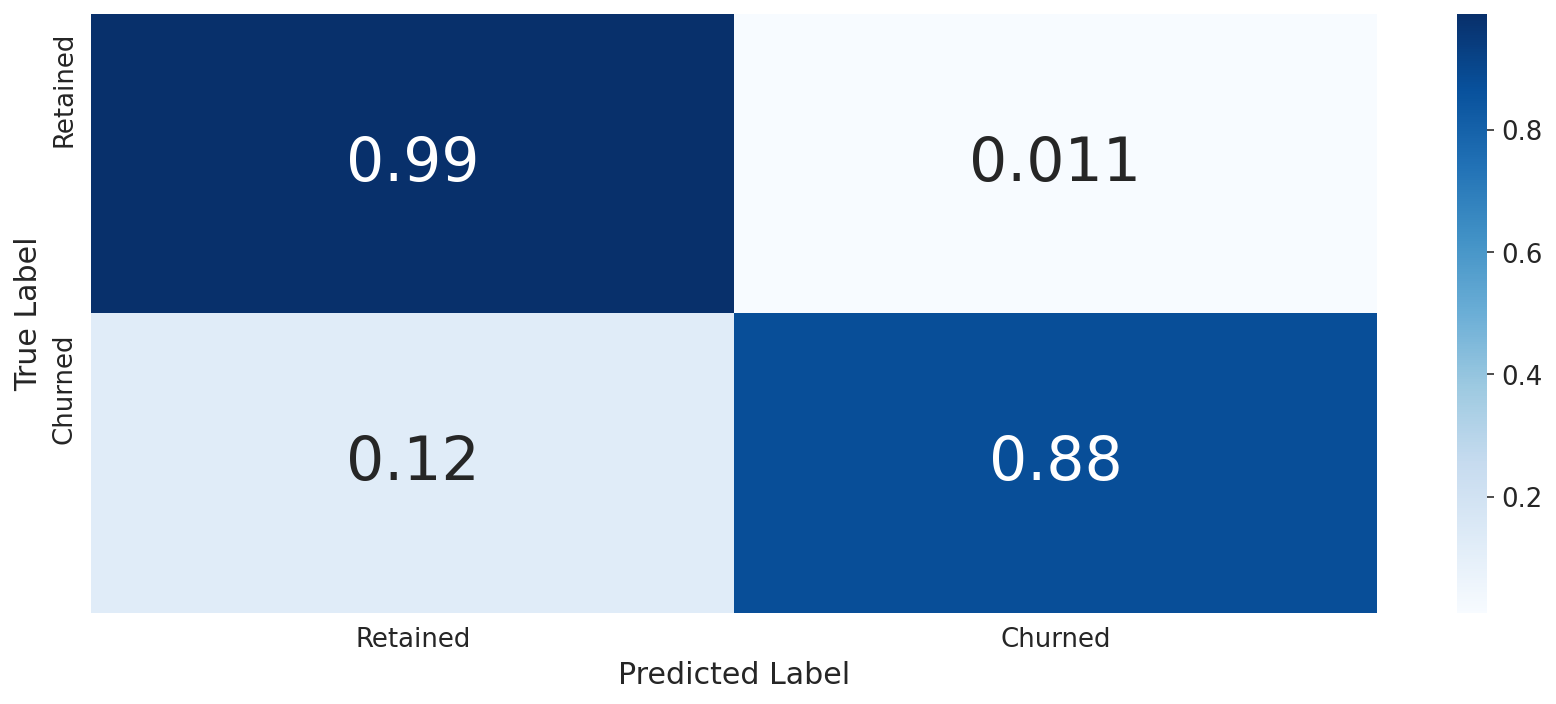

In [28]:
importances = plot_feature_imp(best_rf_clf,feats)
clf_performance(train_df[feats].values, train_df['Churn'].values,best_rf_clf, 'Random Forest', 'RF')

In [ ]:
#### Evaluate on the test set 

In [29]:
test_df = preprocess_test(test_df,preprocess_dict)

fillna for category State
fillna for category Area_Code
fillna for continous No_Vmail_Messages
fillna for continous Total_Day_minutes
target encode for State
one hot encode for Area_Code
label encode for International_Plan
label encode for Voice_Mail_Plan


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


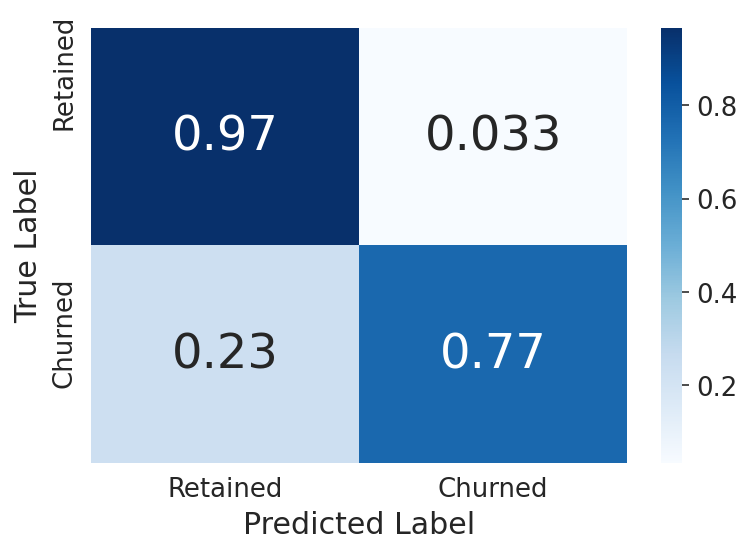

In [30]:
test_func(test_df[feats],test_df['Churn'],best_rf_clf)